# Rarity Index & Predictive Analytics

## Imports

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
from typing import Iterator, List, Dict, Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns
import peptides
import pickle
from functools import reduce
from tqdm import tqdm

# machine learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import Ridge, Lasso

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### LOAD NUCLEOTIDES TEMPLATE

In [2]:
def update_table(df_dna_all):
    # enforce assertions
    total_invertebrate = 2
    total_bacteria = 25237
    total_viruses = 19993
    total_archaea = 338
    total_vertebrate_mammalian = 2
    total_UCSC_genomes = 104
    total_plant = 4
    total_protozoa = 5
    total_fungi = 100
    total_eukaryota = total_protozoa + total_fungi + total_plant + total_UCSC_genomes + total_vertebrate_mammalian + total_invertebrate
    total_species = 45785
    assert total_species == total_bacteria + total_eukaryota + total_viruses + total_archaea
    
    df_dna_all.loc[:, "eukaryota"] = df_dna_all["fungi"] + df_dna_all["UCSC_genomes"] + df_dna_all["protozoa"] + df_dna_all["invertebrate"] + df_dna_all["vertebrate_mammalian"] + df_dna_all["plant"]
    df_dna_all.loc[:, "Rarity for Viruses"] = 1 - df_dna_all["viruses"].div(total_viruses)
    df_dna_all.loc[:, "Rarity for Eukaryota"] = 1 - df_dna_all["eukaryota"].div(total_eukaryota)
    df_dna_all.loc[:, "Rarity for Archaea"] = 1 - df_dna_all["archaea"].div(total_archaea)
    df_dna_all.loc[:, "Rarity for Bacteria"] = 1 - df_dna_all["bacteria"].div(total_bacteria)
    df_dna_all.loc[:, "Rarity Index"] = 1 - df_dna_all["fraction"].div(total_species)
    
    return df_dna_all

In [3]:
def load_nucleotides():
    
    def get_dna_path(length: int) -> Path:
        return Path("/storage/group/izg5139/default/nicole/antikardashian/dna_extractions").joinpath(f"antikardashian_dna_{length}mers.db")

    def get_conn(length: int):
        return sqlite3.connect(get_dna_path(length))

    df_dna_all = []
    for length in tqdm(range(6, 13)):
        temp = pd.read_sql("SELECT * FROM antikardashian;", con=get_conn(length))
        temp.loc[:, "length"] = length
        df_dna_all.append(temp)
            
    df_dna_all = pd.concat(df_dna_all, axis=0)
    return update_table(df_dna_all)
        
df_dna_all = load_nucleotides()
df_dna_all.head()

100%|██████████| 7/7 [02:54<00:00, 24.91s/it]


,kmer,fraction,fungi,UCSC_genomes,archaea,bacteria,viruses,protozoa,plant,invertebrate,vertebrate_mammalian,length,eukaryota,Rarity for Viruses,Rarity for Eukaryota,Rarity for Archaea,Rarity for Bacteria,Rarity Index
0,AAAAAA,43700,100.0,104.0,338.0,25236.0,17909.0,5.0,4.0,2.0,2.0,6,217.0,0.104236,0.0,0.0,0.000040,0.045539
1,AAAAAC,44677,100.0,104.0,338.0,25237.0,18885.0,5.0,4.0,2.0,2.0,6,217.0,0.055419,0.0,0.0,0.000000,0.024200
2,AAAAAG,44757,100.0,104.0,338.0,25237.0,18965.0,5.0,4.0,2.0,2.0,6,217.0,0.051418,0.0,0.0,0.000000,0.022453
3,AAAAAT,44427,100.0,104.0,338.0,25235.0,18637.0,5.0,4.0,2.0,2.0,6,217.0,0.067824,0.0,0.0,0.000079,0.029660
4,AAAACA,44971,100.0,104.0,338.0,25237.0,19179.0,5.0,4.0,2.0,2.0,6,217.0,0.040714,0.0,0.0,0.000000,0.017779


In [4]:
df_dna_all.isna().sum()

kmer                    0
fraction                0
fungi                   0
UCSC_genomes            0
archaea                 0
bacteria                0
viruses                 0
protozoa                0
plant                   0
invertebrate            0
vertebrate_mammalian    0
length                  0
eukaryota               0
Rarity for Viruses      0
Rarity for Eukaryota    0
Rarity for Archaea      0
Rarity for Bacteria     0
Rarity Index            0
dtype: int64

#### LOAD PROTEOMES TEMPLATE

In [5]:
def update_table(df_kmers):
    total_archaea = 340
    total_bacteria = 8623
    total_eukaryota = 2119
    total_viruses = 10789
    total_species_ = 21871
    total_species = total_viruses + total_eukaryota + total_bacteria + total_archaea
    assert total_species == total_species_

    df_kmers.loc[:, "Rarity Index"] = 1 - df_kmers["fraction"].div(total_species)
    df_kmers.loc[:, "Rarity for Archaea"] = 1 - df_kmers["Archaea_proteomes"].div(total_archaea)
    df_kmers.loc[:, "Rarity for Bacteria"] = 1 - df_kmers["Bacteria_proteomes"].div(total_bacteria)
    df_kmers.loc[:, "Rarity for Eukaryota"] = 1 - df_kmers["Eukaryota_proteomes"].div(total_eukaryota)
    df_kmers.loc[:, "Rarity for Viruses"] = 1 - df_kmers["Viruses_proteomes"].div(total_viruses)
    
    return df_kmers

In [6]:
def load_proteomes():
    df_kmers = []

    for length in tqdm(range(2, 7), leave=True, position=0):
        path = Path(f"/storage/group/izg5139/default/nicole/antikardashian/{length}mers_without/merged_bucket_0.db")
        con = sqlite3.connect(path)
        
        df = pd.read_sql("SELECT * FROM antikardashian;", con=con)
        df.loc[:, "length"] = length
        df_kmers.append(df)

    df_kmers = pd.concat(df_kmers, axis=0)
    return update_table(df_kmers)

In [7]:
df_kmers = load_proteomes()
df_kmers.head()

100%|██████████| 5/5 [03:26<00:00, 41.37s/it]


,kmer,fraction,Archaea_proteomes,Bacteria_proteomes,Eukaryota_proteomes,Viruses_proteomes,length,Rarity Index,Rarity for Archaea,Rarity for Bacteria,Rarity for Eukaryota,Rarity for Viruses
0,AA,21535,340.0,8623.0,2119.0,10453.0,2,0.015363,0.0,0.000000,0.000000,0.031143
1,AC,20668,340.0,8622.0,2118.0,9588.0,2,0.055004,0.0,0.000116,0.000472,0.111317
2,AD,21589,340.0,8623.0,2119.0,10507.0,2,0.012894,0.0,0.000000,0.000000,0.026138
3,AE,21629,340.0,8623.0,2119.0,10547.0,2,0.011065,0.0,0.000000,0.000000,0.022430
4,AF,21465,340.0,8623.0,2119.0,10383.0,2,0.018563,0.0,0.000000,0.000000,0.037631


# EDA

### Visualizing Distribution of various Lengths (DNA & Proteomes)

#### DNA

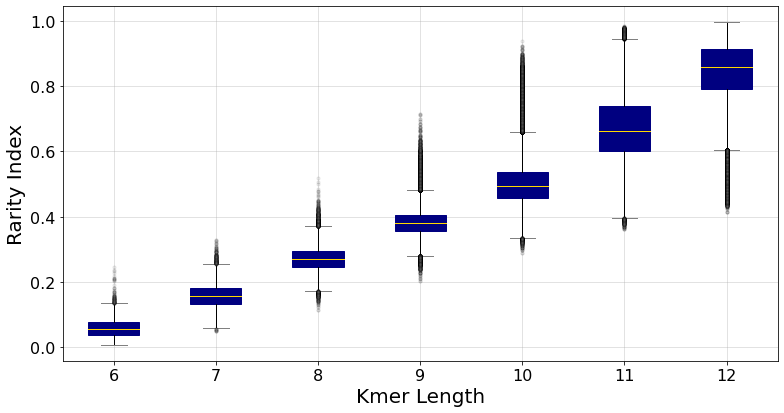

In [9]:
props = dict(boxes="navy", whiskers="Black", medians="Gold", caps="Gray")
flierprops = dict(
                  marker='o', 
                  markerfacecolor='gray', 
                  markersize=3,
                  linestyle='none', 
                  alpha=0.1, 
                  markeredgecolor='black'
    )
                  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
df_dna_all[["length", "Rarity Index"]].boxplot(by="length",
                                          color=props,
                                          flierprops=flierprops,
                                               ax=ax,
                                             patch_artist=True)
plt.suptitle('') 
ax.set_xlabel("Kmer Length")
ax.set_ylabel("Rarity Index")
ax.set_title('')
ax.xaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.label.set_size(20)
ax.grid(lw=0.6, alpha=0.6)
plt.tight_layout()

#### Proteome

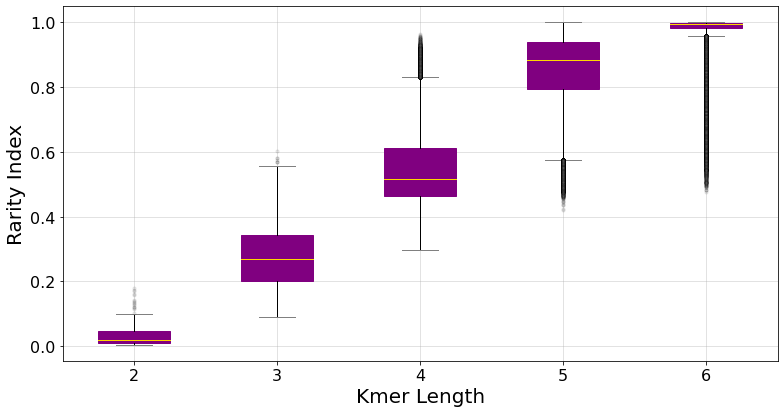

In [10]:
props = dict(boxes="purple", whiskers="Black", medians="Gold", caps="Gray")
flierprops = dict(
                  marker='o', 
                  markerfacecolor='gray', 
                  markersize=3,
                  linestyle='none', 
                  alpha=0.1, 
                  markeredgecolor='black'
    )
                  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
df_kmers[["length", "Rarity Index"]].boxplot(by="length",
                                          color=props,
                                          flierprops=flierprops,
                                               ax=ax,
                                             patch_artist=True)
plt.suptitle('') 
ax.set_xlabel("Kmer Length")
ax.set_ylabel("Rarity Index")
ax.set_title('')
# ax.set_ylim(0)
ax.xaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.label.set_size(20)
ax.grid(lw=0.6, alpha=0.6)
plt.tight_layout();

## Taxonomic Differences in DNA & Proteomic Distributions of Rarity Index

In [11]:
filtered_df = pd.concat([df_kmers['length'], df_kmers.filter(regex="^Rarity for")], axis=1)
filtered_df = pd.melt(filtered_df, id_vars=['length'], var_name='taxonomy', value_name='rarity')\
                    .assign(taxonomy=lambda df: df['taxonomy'].str.extract("for ([A-Z][a-z]+)"))
filtered_df.head()

,length,taxonomy,rarity
0,2,Archaea,0.0
1,2,Archaea,0.0
2,2,Archaea,0.0
3,2,Archaea,0.0
4,2,Archaea,0.0


In [12]:
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

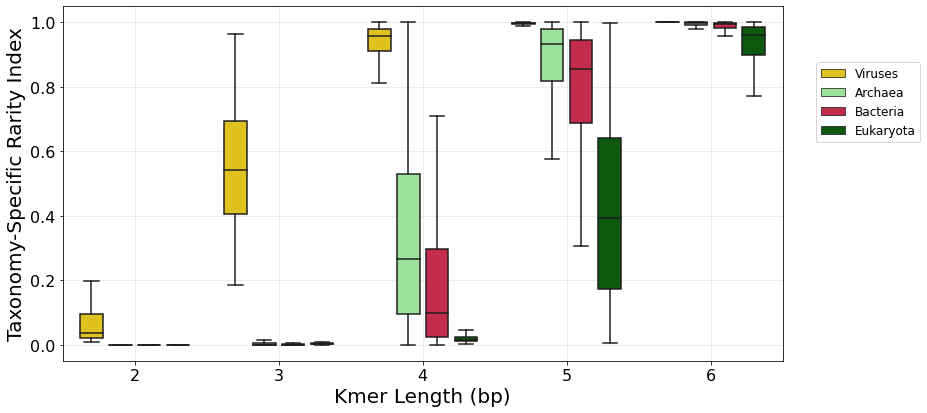

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

props = dict(boxes="navy", whiskers="Black", medians="Gold", caps="Gray")
flierprops = dict(
                  marker='o', 
                  markerfacecolor='gray', 
                  markersize=3,
                  linestyle='none', 
                  alpha=0.1, 
                  markeredgecolor='black'
    )
                  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
sns.boxplot(x="length", y="rarity",
                                          color=props,
                                          flierprops=flierprops,
                                          ax=ax,    
                                          showfliers=False,
                                                hue="taxonomy",
            zorder=3,
            hue_order=["Viruses", "Archaea", "Bacteria", "Eukaryota"],
                                                        palette={"Viruses": "Gold",
                                                                "Archaea": "lightgreen",
                                                                "Eukaryota": "darkgreen",
                                                                "Bacteria": "Crimson",},
           data=filtered_df,
           )

plt.suptitle('') 
ax.set_xlabel("Kmer Length (bp)")
ax.set_ylabel("Taxonomy-Specific Rarity Index")
ax.set_title('')
# ax.set_ylim(0)
ax.xaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.label.set_size(20)
legend = plt.legend(title="",
                    loc=4, 
                    fontsize='large', 
                    fancybox=True,
                    frameon=True,
                   bbox_to_anchor=(1.2, 0.6))
adjust_box_widths(fig, 0.8)
ax.grid(lw=0.6, alpha=0.4, zorder=0)
ax.set_axisbelow(True)
plt.tight_layout()

### Visualizing Correlation between Rarity Index & Length

#### DNA

In [14]:
temp = df_dna_all.groupby("length", as_index=False)\
               .agg({"Rarity Index": "median"})
temp

,length,Rarity Index
0,6,0.056361
1,7,0.155892
2,8,0.271006
3,9,0.379469
4,10,0.492956
5,11,0.662444
6,12,0.859059


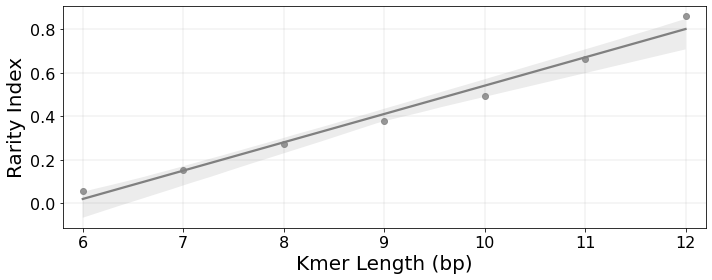

In [15]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.regplot(data=temp,  
            x='length', 
            y='Rarity Index', 
            ax=ax, 

            scatter_kws={"color": "gray"}, 
            line_kws={"color": "gray"},
           )
ax.set_axisbelow(True)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlabel("Kmer Length (bp)")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlim(5.8, 12.2)
plt.tight_layout()

#### Peptides

In [16]:
temp = df_kmers.groupby("length", as_index=False)\
               .agg({"Rarity Index": "median"})
temp

,length,Rarity Index
0,2,0.018449
1,3,0.268255
2,4,0.515523
3,5,0.882676
4,6,0.993233


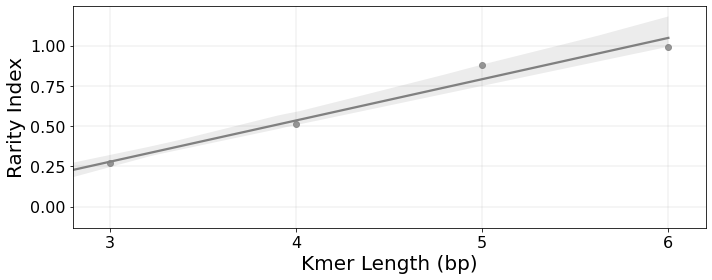

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.regplot(data=temp,  
            x='length', 
            y='Rarity Index', 
            ax=ax, 
            scatter_kws={"color": "gray"}, 
            line_kws={"color": "gray"},
           )
ax.set_axisbelow(True)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_xlabel("Kmer Length (bp)")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlim(2.8, 6.2)
plt.tight_layout()

## Investigating Rarity Index of k-mers in various taxonomies





In the following section we are going to investigate k-mers that are rare in one taxonomy but common in others.

To achieve that, we need a way to measure what's considered common. In order to find the k-mers that are rare only in one taxonomy, 
we filter out k-mers that appear below one standard deviation.

In [23]:
rare_kmers = []

taxonomies = ["Viruses", "Eukaryota", "Archaea", "Bacteria"]
df_6mers = df_kmers[df_kmers['length'] == 6]
for t in tqdm(taxonomies):
    df_s = df_kmers[df_kmers['length'] == 6].copy()
    df_s.loc[:, "RareLabel"] = t
    for taxonomy in ["Viruses", "Eukaryota", "Archaea", "Bacteria"]:
        if t == taxonomy:
            continue
        
        mean = df_s[f'Rarity for {taxonomy}'].mean()
        std = df_s[f'Rarity for {taxonomy}'].std()
        
        df_s = df_s[df_s[f'Rarity for {taxonomy}'] < mean - std]
        
    mean = df_s[f'Rarity for {t}'].mean()
    std = df_s[f'Rarity for {t}'].std()
    
    df_s = df_s.sort_values(by=[f'Rarity for {t}'], ascending=False).head(20)
    rare_kmers.append(df_s)
    print(t, df_s.shape)

 25%|██▌       | 1/4 [00:35<01:46, 35.47s/it]

Viruses (20, 13)


 50%|█████     | 2/4 [01:10<01:10, 35.05s/it]

Eukaryota (20, 13)


 75%|███████▌  | 3/4 [01:45<00:34, 34.95s/it]

Archaea (20, 13)


100%|██████████| 4/4 [02:19<00:00, 34.85s/it]

Bacteria (20, 13)


In [24]:
rare_kmers = pd.concat(rare_kmers, axis=0)\
               .reset_index(drop=True)

rare_kmers

,kmer,fraction,Archaea_proteomes,Bacteria_proteomes,Eukaryota_proteomes,Viruses_proteomes,length,Rarity Index,Rarity for Archaea,Rarity for Bacteria,Rarity for Eukaryota,Rarity for Viruses,RareLabel
0,GYGCTT,4547,64.0,3717.0,766.0,0.0,6,0.792099,0.811765,0.568944,0.638509,1.000000,Viruses
1,PWDGPA,7035,102.0,5629.0,1304.0,0.0,6,0.678341,0.700000,0.347211,0.384615,1.000000,Viruses
2,ILLTSM,4081,71.0,3385.0,625.0,0.0,6,0.813406,0.791176,0.607445,0.705050,1.000000,Viruses
3,PGDPEL,4629,167.0,3756.0,706.0,0.0,6,0.788350,0.508824,0.564421,0.666824,1.000000,Viruses
4,GVQWHP,3553,133.0,2987.0,433.0,0.0,6,0.837547,0.608824,0.653601,0.795658,1.000000,Viruses
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,IPSRMT,2052,85.0,64.0,1875.0,28.0,6,0.906177,0.750000,0.992578,0.115149,0.997405,Bacteria
76,HGQKGV,2337,271.0,67.0,1948.0,51.0,6,0.893146,0.202941,0.992230,0.080698,0.995273,Bacteria
77,ERDCLI,1909,76.0,69.0,1736.0,28.0,6,0.912715,0.776471,0.991998,0.180746,0.997405,Bacteria
78,RQPSLH,2439,281.0,69.0,2029.0,60.0,6,0.888482,0.173529,0.991998,0.042473,0.994439,Bacteria


In [27]:
rare_kmers.to_csv("rare_peptides_6mers_first_20.csv", index=False)

In [64]:
rare_nucleotides = []

taxonomies = ["Viruses", "Eukaryota", "Archaea", "Bacteria"]
df_12mers = df_dna_all[df_dna_all['length'] == 12]
for t in tqdm(taxonomies):
    df_s = df_12mers.copy()
    df_s.loc[:, "RareLabel"] = t
    for taxonomy in ["Viruses", "Eukaryota", "Archaea", "Bacteria"]:
        if t == taxonomy:
            continue
        
        mean = df_s[f'Rarity for {taxonomy}'].mean()
        std = df_s[f'Rarity for {taxonomy}'].std()
        df_s = df_s[df_s[f'Rarity for {taxonomy}'] < mean - std]
        
    mean = df_s[f'Rarity for {t}'].mean()
    std = df_s[f'Rarity for {t}'].std()
    
    df_s = df_s.sort_values(by=[f'Rarity for {t}'], ascending=False).head(20)
    rare_nucleotides.append(df_s)
    print(t, df_s.shape)

 25%|██▌       | 1/4 [00:09<00:27,  9.02s/it]

Viruses (20, 19)


 50%|█████     | 2/4 [00:17<00:17,  8.75s/it]

Eukaryota (20, 19)


 75%|███████▌  | 3/4 [00:26<00:08,  8.66s/it]

Archaea (20, 19)


100%|██████████| 4/4 [00:34<00:00,  8.66s/it]

Bacteria (20, 19)


In [65]:
rare_nucleotides = pd.concat(rare_nucleotides, axis=0)\
               .reset_index(drop=True)

rare_nucleotides[["kmer", "Rarity Index", "RareLabel"]]

,kmer,Rarity Index,RareLabel
0,CCTTGTTACGAC,0.435798,Viruses
1,GTCGTAACAAGG,0.435798,Viruses
2,AGTCGTAACAAG,0.435601,Viruses
3,CTTGTTACGACT,0.435601,Viruses
4,CTTTCCCTCACG,0.487583,Viruses
...,...,...,...
75,GAAGGAGTACAT,0.874915,Bacteria
76,ATCATCCTCCTC,0.873430,Bacteria
77,GAGGAGGATGAT,0.873430,Bacteria
78,TCGTCCTCCTCT,0.871028,Bacteria


In [29]:
rare_nucleotides.to_csv("rare_nucleotides_12mers_first_20.csv", index=False)

## StreamGraph Rolling Dinucleotides

In what follows we will explore relationships of mononucleotide and dinucleotide composition of each k-mer and it's association with the Rarity Index.

In [41]:
# load preprocessed data
def load_preprocessed():
    
    def get_dna_path(length: int) -> Path:
        return Path("/storage/group/izg5139/default/nicole/antikardashian/dna_extractions").joinpath(f"antikardashian_preprocessed_dna_{length}mers.db")

    def get_conn(length: int):
        return sqlite3.connect(get_dna_path(length))

    df_preprocessed_dna = []

    for length in tqdm(range(6, 13)):
        temp = pd.read_parquet(get_dna_path(length))
        temp.loc[:, "length"] = length
        df_preprocessed_dna.append(temp)
    
    return pd.concat(df_preprocessed_dna, axis=0)

df_preprocessed_dna = load_preprocessed()
df_preprocessed_dna.head()

100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


,kmer,fraction,Anti-Kardashian Index,A,C,G,T,AA,AC,AG,...,CT,GA,GC,GG,GT,TA,TC,TG,TT,length
0,AAAAAA,43700,0.045539,6.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,AAAAAC,44677,0.024200,5.0,1.0,0.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,AAAAAG,44757,0.022453,5.0,0.0,1.0,0.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,AAAAAT,44427,0.029660,5.0,0.0,0.0,1.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,AAAACA,44971,0.017779,5.0,1.0,0.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [42]:
df_preprocessed_dna = df_preprocessed_dna.merge(df_dna_all.drop(columns=['fraction', 'length']), 
                                                left_on="kmer", right_on="kmer", how="right")
df_preprocessed_dna.head()

,kmer,fraction,Anti-Kardashian Index,A,C,G,T,AA,AC,AG,...,protozoa,plant,invertebrate,vertebrate_mammalian,eukaryota,Rarity for Viruses,Rarity for Eukaryota,Rarity for Archaea,Rarity for Bacteria,Rarity Index
0,AAAAAA,43700,0.045539,6.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,4.0,2.0,2.0,217.0,0.104236,0.0,0.0,0.000040,0.045539
1,AAAAAC,44677,0.024200,5.0,1.0,0.0,0.0,4.0,1.0,0.0,...,5.0,4.0,2.0,2.0,217.0,0.055419,0.0,0.0,0.000000,0.024200
2,AAAAAG,44757,0.022453,5.0,0.0,1.0,0.0,4.0,0.0,1.0,...,5.0,4.0,2.0,2.0,217.0,0.051418,0.0,0.0,0.000000,0.022453
3,AAAAAT,44427,0.029660,5.0,0.0,0.0,1.0,4.0,0.0,0.0,...,5.0,4.0,2.0,2.0,217.0,0.067824,0.0,0.0,0.000079,0.029660
4,AAAACA,44971,0.017779,5.0,1.0,0.0,0.0,3.0,1.0,0.0,...,5.0,4.0,2.0,2.0,217.0,0.040714,0.0,0.0,0.000000,0.017779


In [43]:
df_preprocessed_dna.columns

Index(['kmer', 'fraction', 'Anti-Kardashian Index', 'A', 'C', 'G', 'T', 'AA',
       'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA',
       'TC', 'TG', 'TT', 'length', 'fungi', 'UCSC_genomes', 'archaea',
       'bacteria', 'viruses', 'protozoa', 'plant', 'invertebrate',
       'vertebrate_mammalian', 'eukaryota', 'Rarity for Viruses',
       'Rarity for Eukaryota', 'Rarity for Archaea', 'Rarity for Bacteria',
       'Rarity Index'],
      dtype='object')

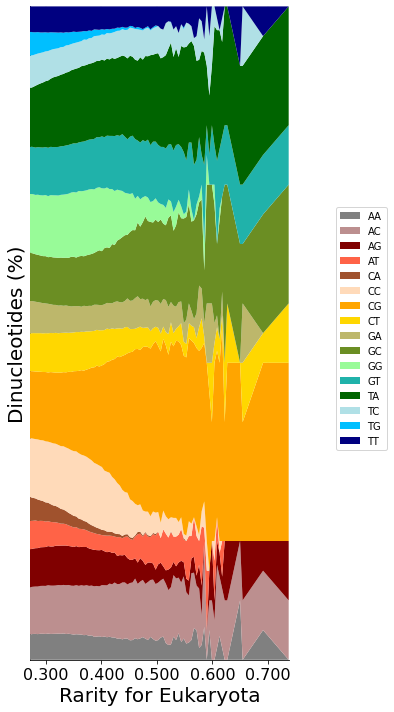

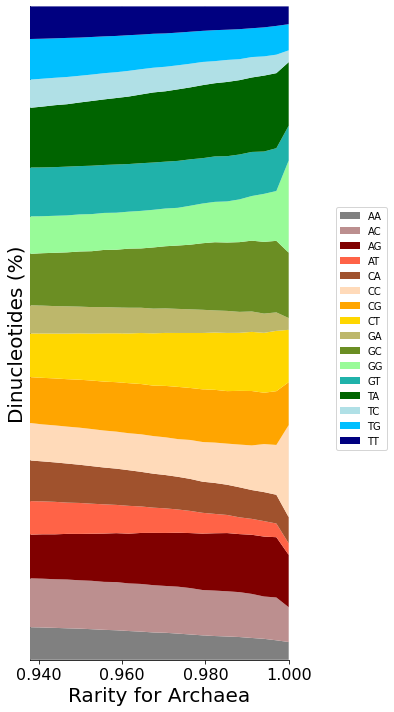

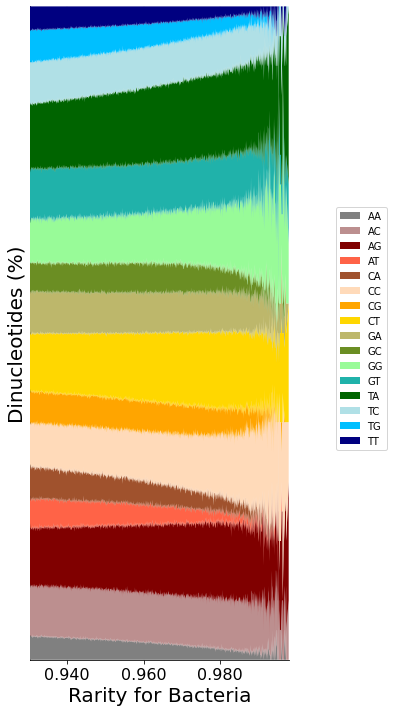

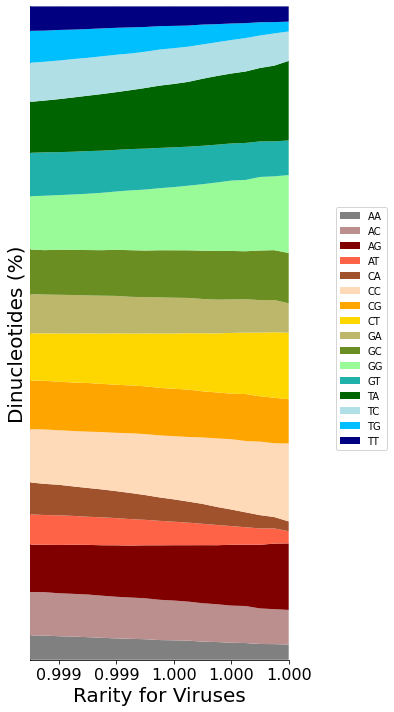

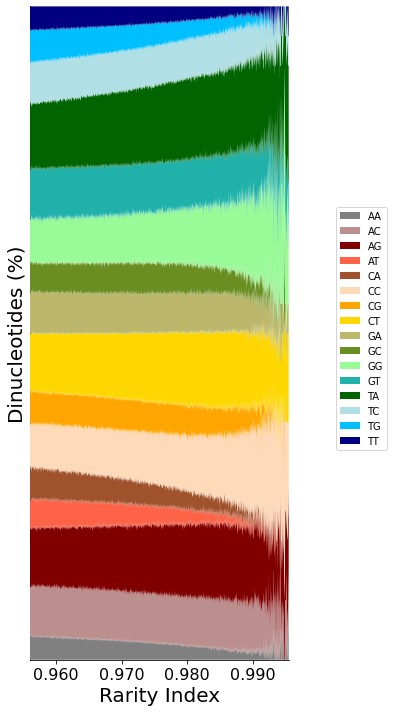

In [44]:
from matplotlib.ticker import FormatStrFormatter
    
groupby_features =["Rarity for Eukaryota",
                   "Rarity for Archaea",
                   "Rarity for Bacteria",
                   "Rarity for Viruses",
                   "Rarity Index"]
colors = ["grey", 
          "rosybrown", 
          "maroon", 
          "tomato", 
          "sienna",
          "peachpuff", 
          "orange", 
          "gold", 
          "darkkhaki", 
          "olivedrab", 
          "palegreen",
          "lightseagreen", 
          "darkgreen", 
          "powderblue", 
          "deepskyblue", 
          "navy", 
          "blueviolet", 
          "violet", 
          "deeppink", 
          "darkviolet"
         ]
    
for groupby_feature in groupby_features:
    for length in range(12, 13):

        df_dinucleotides = df_preprocessed_dna[df_preprocessed_dna["length"] == length][[groupby_feature] + [col for col in df_preprocessed_dna.columns if len(col) == 2]]

        species = df_dinucleotides.groupby(groupby_feature, as_index=False)\
                        .mean()\
                        .sort_values(by=[groupby_feature])
        species = species.set_index(groupby_feature)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 10))
        ax.stackplot(species.index,
                     species.T,
                     labels=species.columns,
                     colors=colors,
                     zorder=3
                    )
        ax.grid(lw=0.4, alpha=0.6, zorder=0)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        ax.set_xlabel(groupby_feature.replace("Anti-Kardashian", "Rarity"))
        ax.set_ylabel("Dinucleotides (%)")
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.tick_params(axis="both", which="major", labelsize=16)
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.set_xlim(xmin=df_preprocessed_dna[groupby_feature].quantile(0.95),
                    xmax=df_preprocessed_dna[groupby_feature].max()
                )

        ax.set_ylim(ymax=length-1)
        ax.legend(loc=0, bbox_to_anchor=(1.4, 0.7))
        plt.tight_layout()
        plt.show()

## General Statistics and Histplot of Rarity Index Increase

#### DNA

In [45]:
import matplotlib.gridspec as gridspec

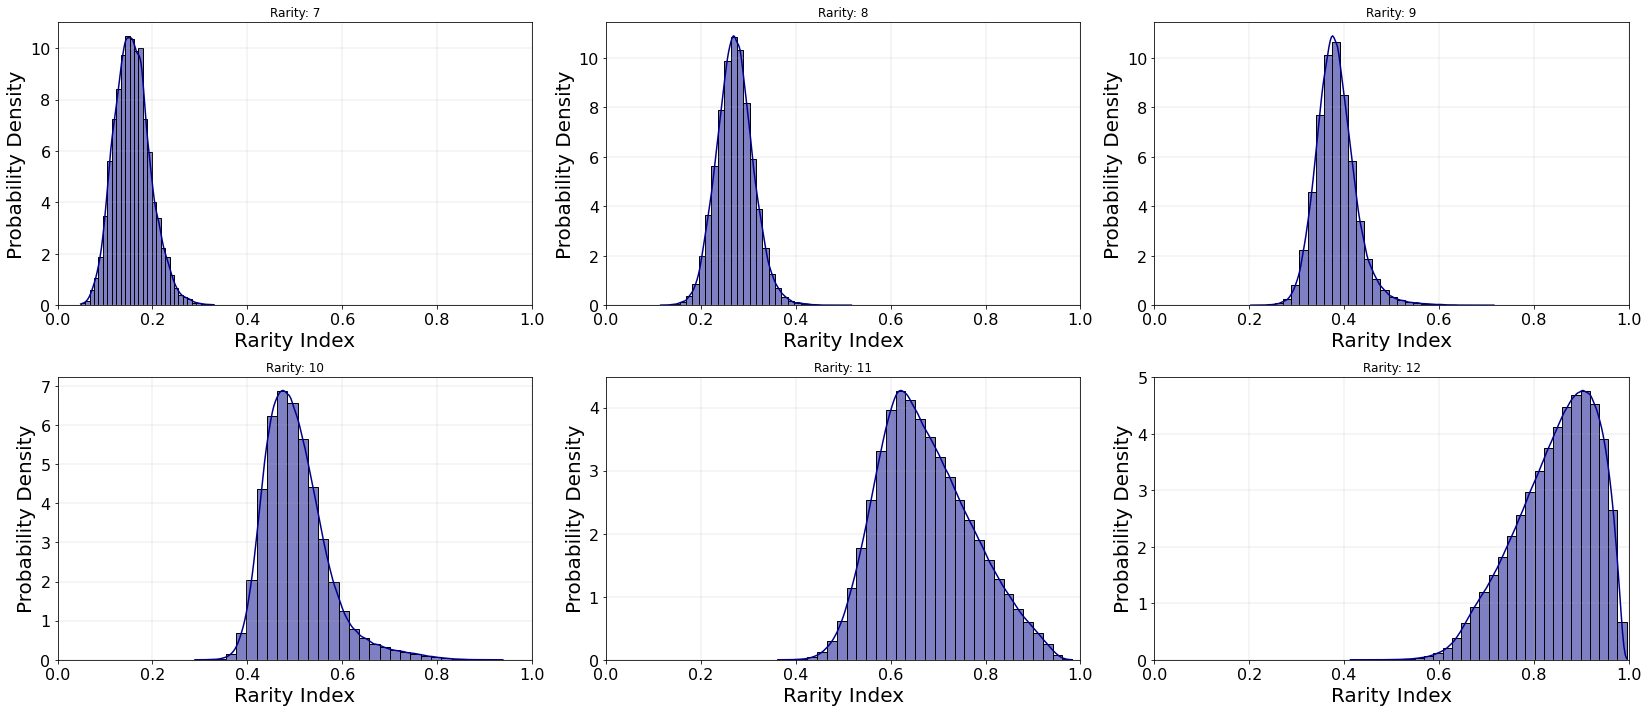

In [46]:
fig = plt.figure(tight_layout=True, figsize=(23, 10))
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
axes = []

for i in range(2):
    for j in range(3):
        axes.append(fig.add_subplot(spec[i, j]))

statistics_df = []
for length in range(7, 13):
    ax = axes[length-7]
    df_dna_kmers = df_dna_all[df_dna_all['length'] == length]
    statistics_df.append({
                         "length": length,
                          "mean_rarity": df_dna_kmers['Rarity Index'].mean(),
                          "std_rarity": df_dna_kmers['Rarity Index'].std(),
                         })

    sns.histplot(data=df_dna_kmers, 
                     ax=ax, 
                     kde=True, 
                     color="darkblue",
                     stat="density",
                     bins=30,
                     x="Rarity Index")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.grid(lw=0.4, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0.0, 1.0)
    ax.set_xlabel("Rarity Index")
    ax.set_ylabel("Probability Density")
    ax.set_title(f"Rarity: {length}")


plt.tight_layout()

In [47]:
statistics_df = pd.DataFrame(statistics_df)
statistics_df.head()

,length,mean_rarity,std_rarity
0,7,0.157806,0.038010
1,8,0.271895,0.038523
2,9,0.382631,0.042372
3,10,0.503189,0.068180
4,11,0.673986,0.097715


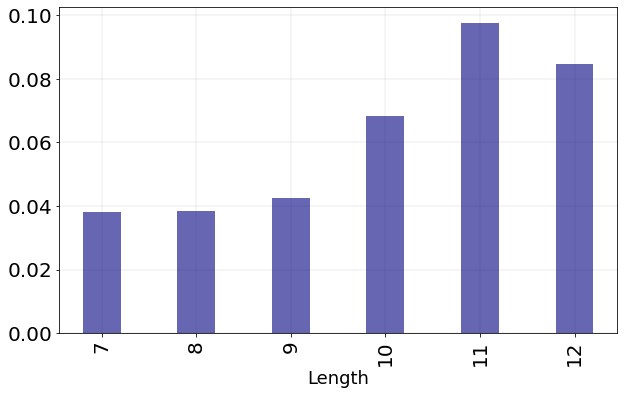

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

statistics_df.set_index("length")[["std_rarity"]].plot(kind="bar", 
                                                       ax=ax, 
                                                       width=0.4, 
                                                       alpha=0.6, 
                                                       color='navy', 
                                                       zorder=3)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.tick_params(which="both", labelsize=20, axis="both")
ax.set_xlabel("Length")
ax.xaxis.label.set_size(18)
ax.legend(handles=[], frameon=False);

#### Proteome

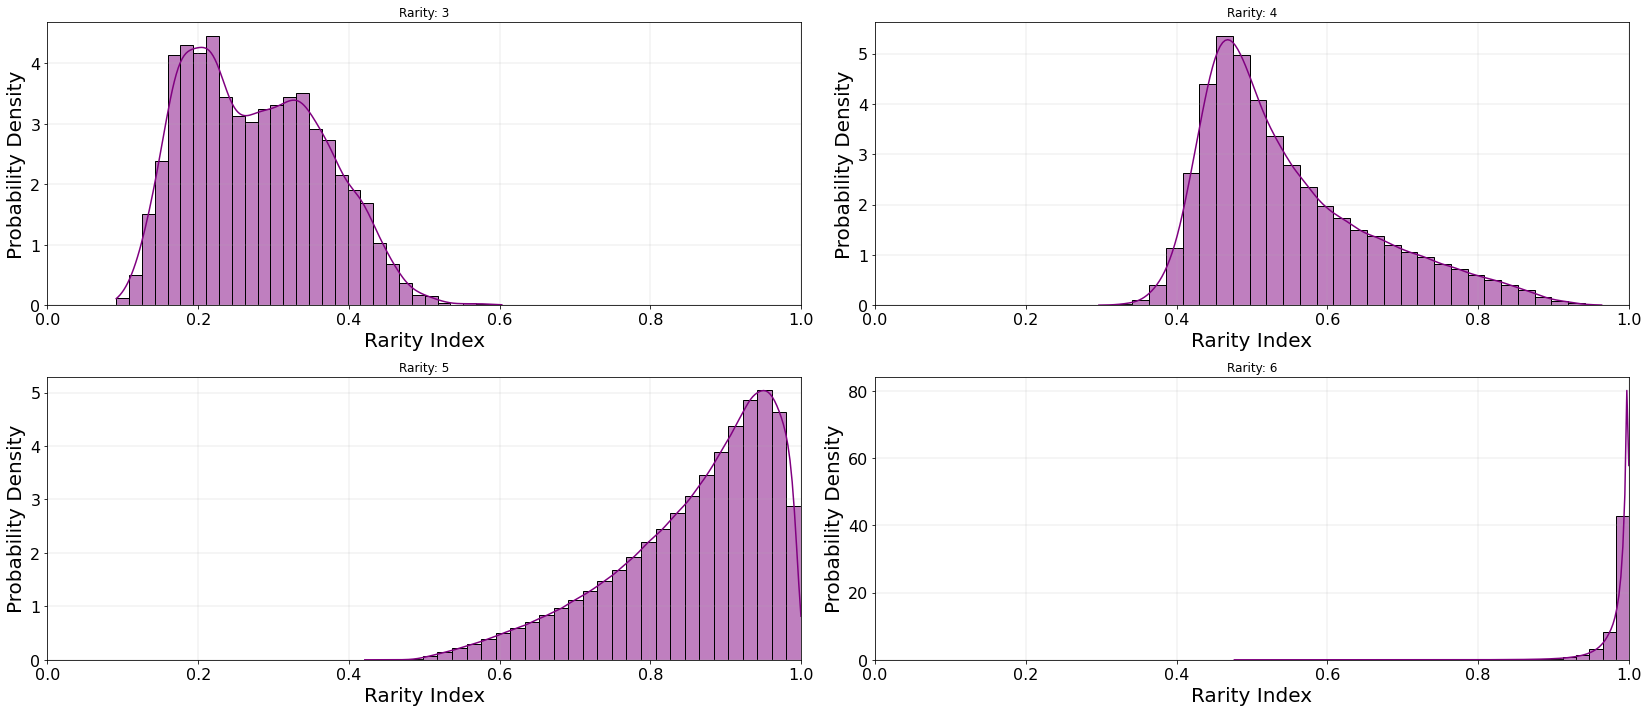

In [53]:
fig = plt.figure(tight_layout=True, figsize=(23, 10))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
axes = []

for i in range(2):
    for j in range(2):
        axes.append(fig.add_subplot(spec[i, j]))

statistics_df = []

for length in range(3, 7):
    ax = axes[length-3]
    df_kmers_slice = df_kmers[df_kmers['length'] == length]
    statistics_df.append({
                         "length": length,
                          "mean_rarity": df_kmers_slice['Rarity Index'].mean(),
                          "std_rarity": df_kmers_slice['Rarity Index'].std(),
                         }
                        )

    sns.histplot(data=df_kmers_slice, 
                     ax=ax, 
                     kde=True, 
                     color="purple",
                     stat="density",
                     bins=30,
                     x="Rarity Index")
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.grid(lw=0.4, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlim(0.0, 1.0)
    ax.set_xlabel("Rarity Index")
    ax.set_ylabel("Probability Density")
    ax.set_title(f"Rarity: {length}")

plt.tight_layout()

## Predictive Analytics

In the following section we will train a Ridge Regression model to predict the Rarity Index of a given k-mer by its dinucleotide and mononucleotide composition.

Note that, the Random Forest Regressor was trained on the HPC.

### DNA

In [82]:
from collections import Counter, defaultdict

def calculate_kmer(kmer, length):
    if length == 1:
        return dict(Counter(kmer))
    
    counts = defaultdict(int)
    for i in range(len(kmer)-length+1):
        counts[kmer[i:i+length]] += 1
    return dict(counts)

In [83]:
calculate_kmer("AAGAGAG", 2)

{'AA': 1, 'AG': 3, 'GA': 2}

In [89]:
df_preprocessed = {}
for length in range(6, 10):    
    rows = []
    sliced = df_dna_all[df_dna_all['length'] == length].reset_index(drop=True)

    for _, row in tqdm(sliced.iterrows(), total=sliced.shape[0], leave=True, position=0):
        kmer = row['kmer']
        mononucleotides = calculate_kmer(kmer, 1)
        dinucleotides = calculate_kmer(kmer, 2)
        dinucleotides.update(mononucleotides)
        rows.append(dinucleotides)
        
    rows = pd.DataFrame(rows).fillna(0.0)
    sliced = pd.concat([sliced, rows], axis=1)
    df_preprocessed.update({length: sliced})

100%|██████████| 262144/262144 [00:25<00:00, 10239.35it/s]


In [90]:
df_preprocessed[6].head(2)

,kmer,fraction,fungi,UCSC_genomes,archaea,bacteria,viruses,protozoa,plant,invertebrate,...,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,AAAAAA,43700,100.0,104.0,338.0,25236.0,17909.0,5.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAAAAC,44677,100.0,104.0,338.0,25237.0,18885.0,5.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from statsmodels.regression import linear_model

coef_df_nucleotides = pd.DataFrame([], columns=["features", "importance", "length", "fold_id"])
train_mean_scores = {}
train_std_scores = {}
test_mean_scores = {}
test_std_scores = {}
scores = defaultdict(list)
predictions_df = pd.DataFrame([], columns=["length", "Predicted Value", "Rarity Index"])
df_processed = df_dna_kmers


for length in range(6, 10):
    print(f"Cross validating for kmer length {length}...")
    df_trans = df_preprocessed[length][["Rarity Index"] + [col for col in df_preprocessed[length].columns if len(col) == 1 or len(col) == 2]]
    X_trans_ = df_trans.drop(columns=["Rarity Index"])
    y = df_trans["Rarity Index"]
    cv = KFold(n_splits=10)
    train_scores = []
    test_scores = []
    for fold_id, (train_indices, test_indices) in tqdm(list(enumerate(cv.split(X_trans_, y)))):
        X_trans_train = X_trans_.iloc[train_indices]
        X_trans_test = X_trans_.iloc[test_indices]
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
        
        model = Ridge(alpha=0.1)
        model.fit(X_trans_train, y_train)
        
        y_pred = pd.DataFrame(model.predict(X_trans_test), columns=["Predicted Value"])
        temp = pd.concat([y_test.to_frame(name="Rarity Index").reset_index(drop=True), y_pred], axis=1)
        temp.loc[:, "length"] = length
        predictions_df = pd.concat([predictions_df, temp], 
                                   axis=0).reset_index(drop=True)
        
        coef_up = pd.DataFrame(model.coef_, 
                               index=X_trans_.columns).reset_index()
        coef_up.columns = ["features", "importance"]
        coef_up.loc[:, "length"] = length
        coef_up.loc[:, "fold_id"] = fold_id
        coef_df_nucleotides = pd.concat([coef_df_nucleotides, coef_up], 
                                        axis=0).reset_index(drop=True)

        train_scores.append(model.score(X_trans_train, y_train))
        test_scores.append(model.score(X_trans_test, y_test))
        
        scores["fold_id"].append(fold_id)
        scores["length"].append(length)
        scores["train_score"].append(train_scores[-1])
        scores["test_score"].append(test_scores[-1])


    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    print(f"(Length {fold_id}) Train scores: {train_scores}.")
    print(f"(Length {fold_id}) Test scores: {test_scores}.")
    print()
    
    train_mean_scores.update({length: train_scores.mean()})
    train_std_scores.update({length: train_scores.std()})
    test_mean_scores.update({length: test_scores.mean()})
    test_std_scores.update({length: test_scores.std()})
scores = pd.DataFrame(scores)
scores.head()


100%|██████████| 10/10 [00:00<00:00, 63.50it/s][A

  0%|          | 0/10 [00:00<?, ?it/s]

Cross validating for kmer length 6...
(Length 9) Train scores: [0.55224869 0.56368925 0.55694774 0.5376313  0.54570872 0.55160852
 0.56518377 0.56552748 0.55778058 0.55604756].
(Length 9) Test scores: [0.50772129 0.45596928 0.45772339 0.59864708 0.57375991 0.56908111
 0.43379335 0.41346097 0.51518928 0.38362907].

Cross validating for kmer length 7...



100%|██████████| 10/10 [00:00<00:00, 50.61it/s][A

 30%|███       | 3/10 [00:00<00:00, 27.32it/s]

(Length 9) Train scores: [0.63564917 0.64660359 0.64003628 0.62634755 0.63398989 0.64052881
 0.64620142 0.6476377  0.63908639 0.63718469].
(Length 9) Test scores: [0.6068898  0.55880661 0.56344201 0.67615139 0.63400555 0.62151
 0.5240747  0.51730414 0.63087485 0.5622881 ].

Cross validating for kmer length 8...



100%|██████████| 10/10 [00:00<00:00, 24.67it/s][A

  0%|          | 0/10 [00:00<?, ?it/s]

(Length 9) Train scores: [0.56431208 0.57580272 0.5692655  0.56140202 0.56657908 0.5722657
 0.57426921 0.57443376 0.57198029 0.56482066].
(Length 9) Test scores: [0.54427688 0.49740245 0.50803864 0.58000277 0.54663564 0.54135831
 0.46559706 0.49509621 0.53461539 0.53202412].

Cross validating for kmer length 9...



100%|██████████| 10/10 [00:01<00:00,  6.37it/s]

(Length 9) Train scores: [0.49056821 0.50363926 0.49618398 0.49020936 0.49819021 0.4977767
 0.50032681 0.50437043 0.49852268 0.4929988 ].
(Length 9) Test scores: [0.48404602 0.42900288 0.44339955 0.50875152 0.44315776 0.49132708
 0.4164488  0.40408605 0.47388215 0.47289008].



,fold_id,length,train_score,test_score
0,0,6,0.552249,0.507721
1,1,6,0.563689,0.455969
2,2,6,0.556948,0.457723
3,3,6,0.537631,0.598647
4,4,6,0.545709,0.573760


## DNA Coefficient Importance

In [93]:
scores.groupby("length").mean()

,fold_id,train_score,test_score
length,,,
6,4.5,0.555237,0.490897
7,4.5,0.639327,0.589535
8,4.5,0.569513,0.524505
9,4.5,0.497279,0.456699


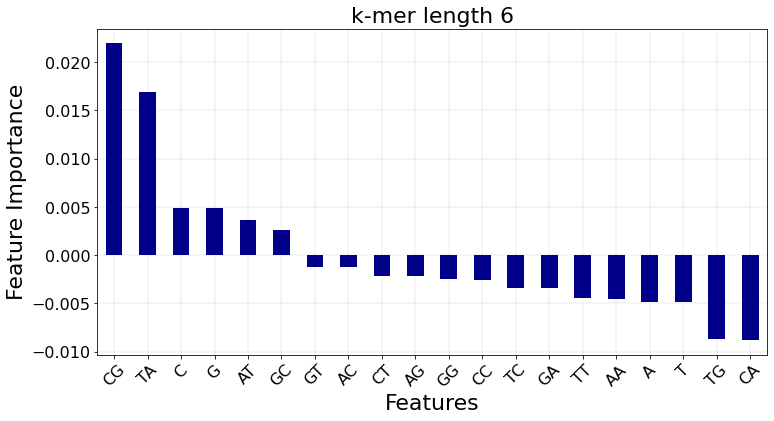

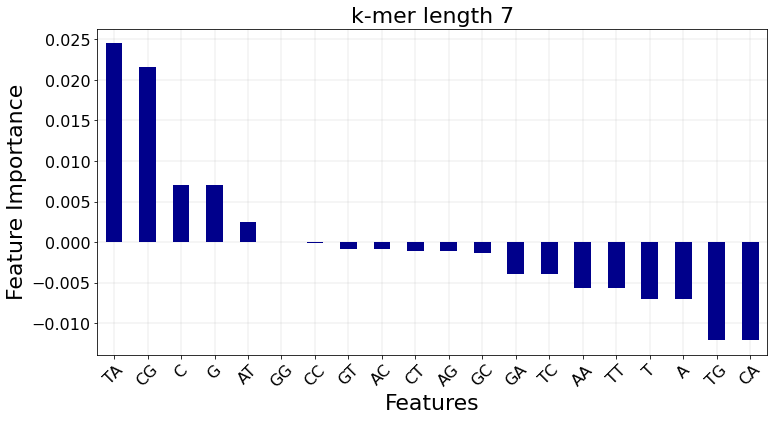

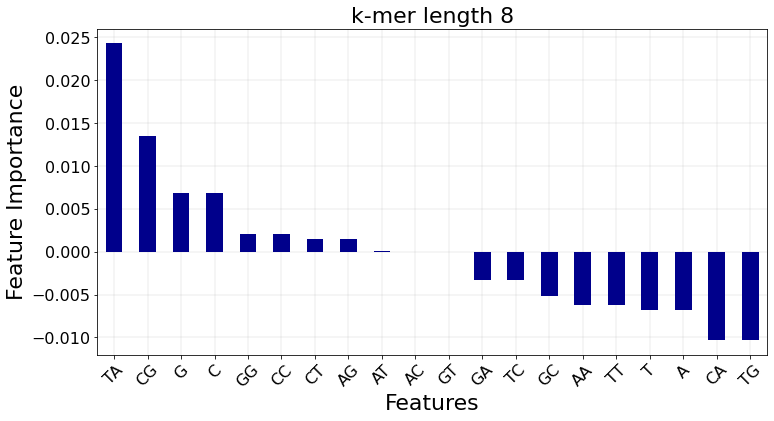

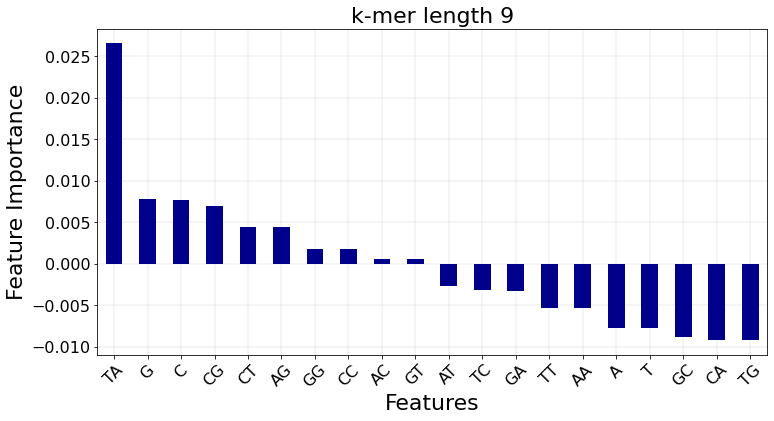

In [95]:
for length in range(6, 10):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    temp = coef_df_nucleotides[coef_df_nucleotides["length"] == length]
    temp = temp.groupby("features")\
                .agg({"importance": "mean"})\
                .sort_values(by=["importance"], ascending=False)
    
    temp.plot(kind="bar", ax=ax, rot=45, zorder=3, color="darkblue")
    
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("Features")
    ax.set_ylabel("Feature Importance")
    ax.xaxis.label.set_size(22)
    ax.legend(handles=[], frameon=False)
    ax.yaxis.label.set_size(22)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_title(f"k-mer length {length}")
    ax.title.set_size(22)
    ax.set_xticks(range(len(temp.index)), [tick.replace(" ", "-") for tick in temp.index])
    plt.show()

### DNA Test Scores

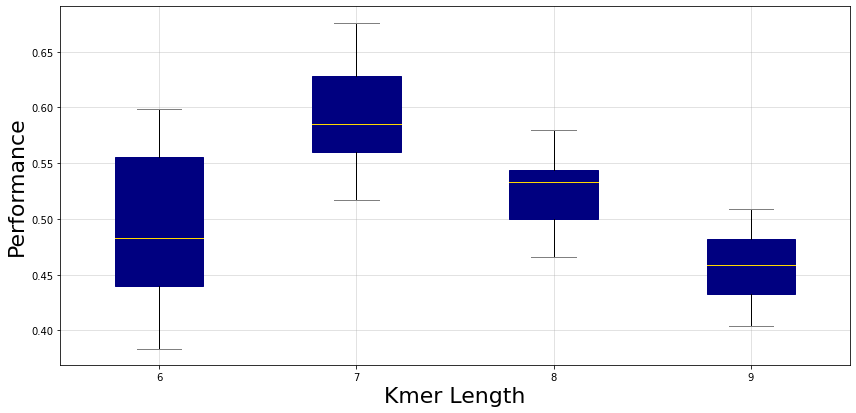

In [96]:
props = dict(boxes="Navy", whiskers="Black", medians="Gold", caps="Gray")
flierprops = dict(
                  marker='o', 
                  markerfacecolor='gray', 
                  markersize=3,
                  linestyle='none', 
                  alpha=0.1, 
                  markeredgecolor='black'
    )
                  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
scores[["length", "test_score"]].boxplot(by="length",
                                          color=props,
                                          flierprops=flierprops,
                                               ax=ax,
                                             patch_artist=True,
                                        zorder=3)
plt.suptitle('') 
ax.set_xlabel("Kmer Length")
ax.set_ylabel("Performance")
ax.set_title('')
# ax.set_ylim(0)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.grid(lw=0.6, alpha=0.6, zorder=0)
plt.tight_layout();

### DNA Predicted Rarity Index vs. True Rarity Index


  0%|          | 0/4 [00:00<?, ?it/s]

Length 6


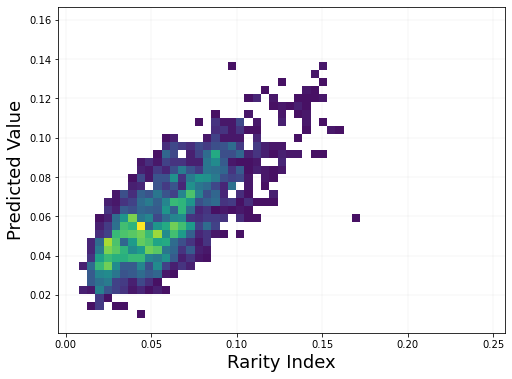


 25%|██▌       | 1/4 [00:00<00:00,  3.38it/s]

Length 7


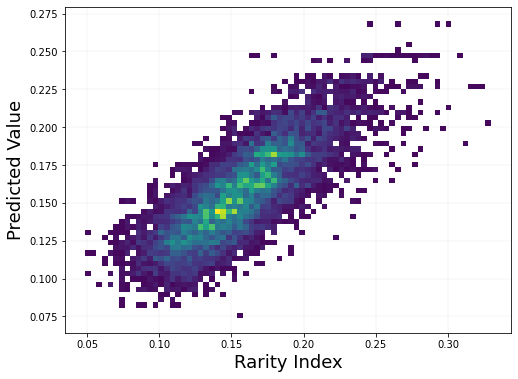


 50%|█████     | 2/4 [00:00<00:00,  3.27it/s]

Length 8


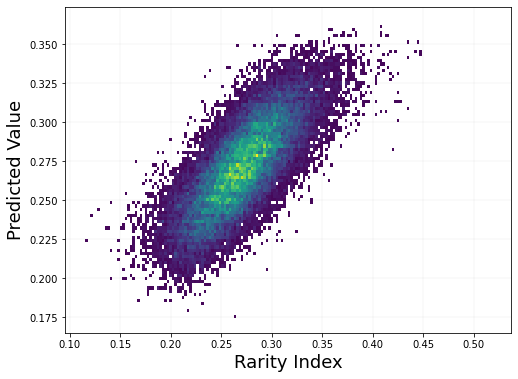


 75%|███████▌  | 3/4 [00:00<00:00,  3.01it/s]

Length 9


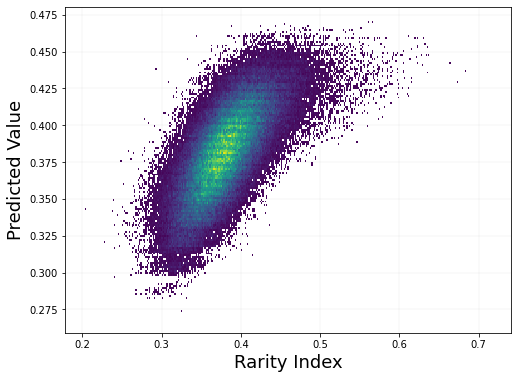


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


In [98]:
for length in tqdm(range(6, 10)):
    print(f"Length {length}")
    predictions_df_slice = predictions_df[predictions_df["length"] == length]
    X = predictions_df_slice[["Rarity Index"]]
    y = predictions_df_slice["Predicted Value"]
    X_trans = X
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    sns.histplot(data=predictions_df_slice, 
                x="Rarity Index", 
                y="Predicted Value", 
                 pthresh=0.0, 
                 ax=ax,
                 cmap="viridis",
                zorder=3)
    ax.set_xlabel("Rarity Index")
    ax.xaxis.label.set_size(18)
    ax.grid(lw=0.4, alpha=0.3, zorder=0)
    ax.yaxis.label.set_size(18)
    plt.show()

## Peptides

In [99]:
df_preprocessed = {}
for length in range(3, 5):    
    rows = []
    sliced = df_kmers[df_kmers['length'] == length].reset_index(drop=True)
    
    for _, row in tqdm(sliced.iterrows(), total=sliced.shape[0], leave=True, position=0):
        kmer = row['kmer']
        monopeptides = calculate_kmer(kmer, 1)
        dipeptides = calculate_kmer(kmer, 2)
        dipeptides.update(monopeptides)
        rows.append(dipeptides)
        
    rows = pd.DataFrame(rows).fillna(0.0)
    sliced = pd.concat([sliced, rows], axis=1)
    df_preprocessed.update({length: sliced})

100%|██████████| 160000/160000 [00:14<00:00, 10786.69it/s]


In [111]:
coef_df_peptides = pd.DataFrame([], columns=["features", "importance", "length", "fold_id"])

train_mean_scores = {}
train_std_scores = {}
test_mean_scores = {}
test_std_scores = {}
scores = defaultdict(list)

predictions_df = pd.DataFrame([], columns=["length", "Predicted Value", "Rarity Index"])

df_processed = df_dna_kmers

for length in range(3, 5):
    print(f"Cross validating for kmer length {length}...")
    df_trans = df_preprocessed[length][["Rarity Index"] + [col for col in df_preprocessed[length].columns if len(col) == 1 or len(col) == 2]]
    X_trans_ = df_trans.drop(columns=["Rarity Index"])
    y = df_trans["Rarity Index"]
    cv = KFold(n_splits=10)
    train_scores = []
    test_scores = []
    for fold_id, (train_indices, test_indices) in tqdm(list(enumerate(cv.split(X_trans_, y)))):
        X_trans_train = X_trans_.iloc[train_indices]
        X_trans_test = X_trans_.iloc[test_indices]
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
        
        model = Ridge(alpha=0.1)
        model.fit(X_trans_train, y_train)
        
        y_pred = pd.DataFrame(model.predict(X_trans_test), columns=["Predicted Value"])
        temp = pd.concat([y_test.to_frame(name="Rarity Index").reset_index(drop=True), y_pred], axis=1)
        temp.loc[:, "length"] = length
        predictions_df = pd.concat([predictions_df, temp], 
                                   axis=0).reset_index(drop=True)
        
        coef_up = pd.DataFrame(model.coef_, 
                               index=X_trans_.columns).reset_index()
        coef_up.columns = ["features", "importance"]
        coef_up.loc[:, "length"] = length
        coef_up.loc[:, "fold_id"] = fold_id
        coef_df_peptides = pd.concat([coef_df_peptides, coef_up], 
                                        axis=0).reset_index(drop=True)

        train_scores.append(model.score(X_trans_train, y_train))
        test_scores.append(model.score(X_trans_test, y_test))
        
        scores["fold_id"].append(fold_id)
        scores["length"].append(length)
        scores["train_score"].append(train_scores[-1])
        scores["test_score"].append(test_scores[-1])


    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    print(f"(Length {fold_id}) Train scores: {train_scores}.")
    print(f"(Length {fold_id}) Test scores: {test_scores}.")
    print()
    
    train_mean_scores.update({length: train_scores.mean()})
    train_std_scores.update({length: train_scores.std()})
    test_mean_scores.update({length: test_scores.mean()})
    test_std_scores.update({length: test_scores.std()})
scores = pd.DataFrame(scores)
scores.head()


 10%|█         | 1/10 [00:00<00:01,  8.56it/s]

Cross validating for kmer length 3...



100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


(Length 9) Train scores: [0.97993617 0.98077158 0.98032738 0.98068029 0.97987217 0.97996336
 0.9806777  0.97984387 0.97950974 0.97996681].
(Length 9) Test scores: [0.97434944 0.9642605  0.97517091 0.97005705 0.97412492 0.967046
 0.97055546 0.97791363 0.9810638  0.96379029].

Cross validating for kmer length 4...



100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

(Length 9) Train scores: [0.94898593 0.94399731 0.94452825 0.94398638 0.94390827 0.94354911
 0.94409056 0.94332076 0.94317757 0.94261619].
(Length 9) Test scores: [0.90761024 0.9381644  0.93369909 0.94277426 0.93822839 0.93734457
 0.94287178 0.94770013 0.94623972 0.93401413].



,fold_id,length,train_score,test_score
0,0,3,0.979936,0.974349
1,1,3,0.980772,0.964260
2,2,3,0.980327,0.975171
3,3,3,0.980680,0.970057
4,4,3,0.979872,0.974125


## Peptides Test Scores

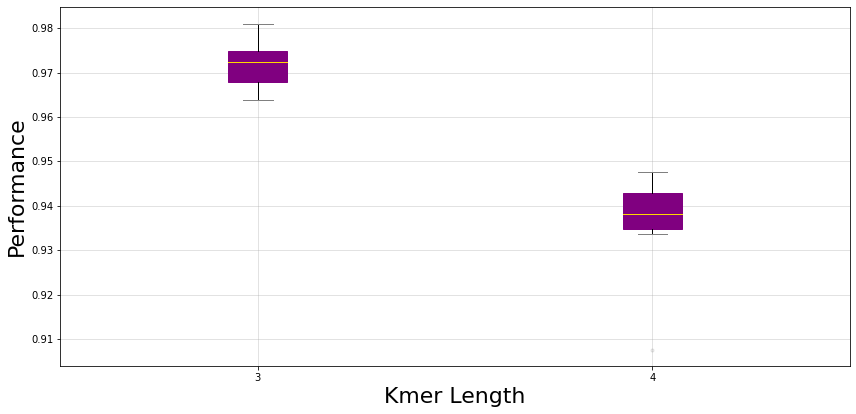

In [112]:
props = dict(boxes="purple", whiskers="Black", medians="Gold", caps="Gray")
flierprops = dict(
                  marker='o', 
                  markerfacecolor='gray', 
                  markersize=3,
                  linestyle='none', 
                  alpha=0.1, 
                  markeredgecolor='black'
    )
                  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
scores[["length", "test_score"]].boxplot(by="length",
                                          color=props,
                                          flierprops=flierprops,
                                               ax=ax,
                                             patch_artist=True,
                                        zorder=3)
plt.suptitle('') 
ax.set_xlabel("Kmer Length")
ax.set_ylabel("Performance")
ax.set_title('')
# ax.set_ylim(0)
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.grid(lw=0.6, alpha=0.6, zorder=0)
plt.tight_layout();

## Peptides Coefficient Importance (Ridge)

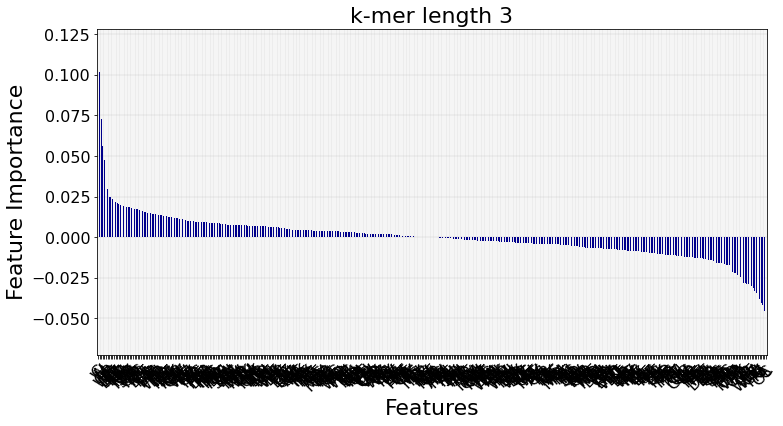

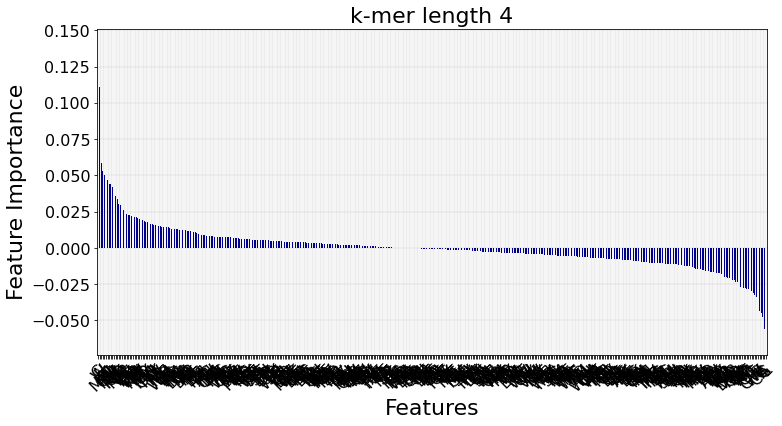

In [113]:
for length in range(3, 5):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    temp = coef_df_peptides[coef_df_peptides["length"] == length]
    temp = temp.groupby("features")\
                .agg({"importance": "mean"})\
                .sort_values(by=["importance"], ascending=False)
    
    temp.plot(kind="bar", ax=ax, rot=45, zorder=3, color="darkblue")
    
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_xlabel("Features")
    ax.set_ylabel("Feature Importance")
    ax.xaxis.label.set_size(22)
    ax.legend(handles=[], frameon=False)
    ax.yaxis.label.set_size(22)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_title(f"k-mer length {length}")
    ax.title.set_size(22)
    ax.set_xticks(range(len(temp.index)), [tick.replace(" ", "-") for tick in temp.index])
    plt.show()

## Visualizing taxonomic relationships


  0%|          | 0/4 [00:00<?, ?it/s]

Processing Length 3


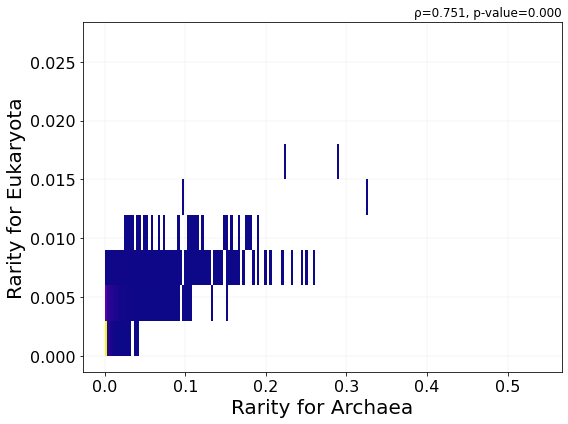

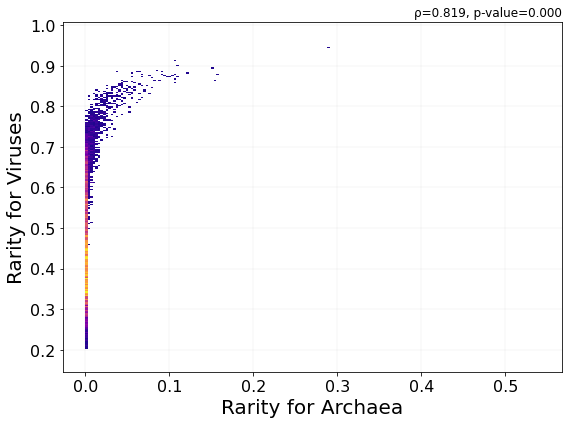

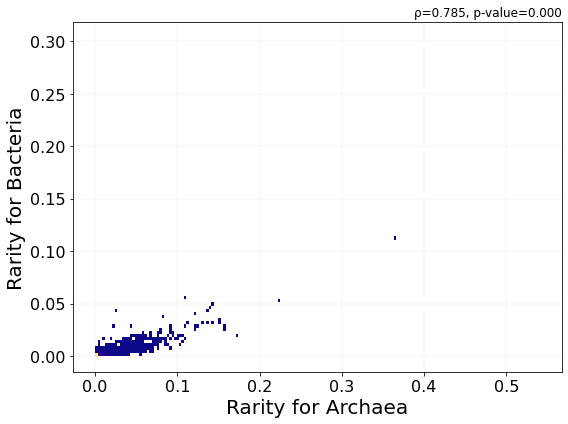

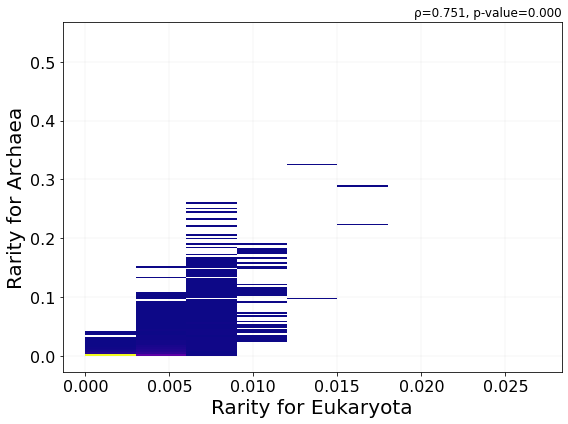

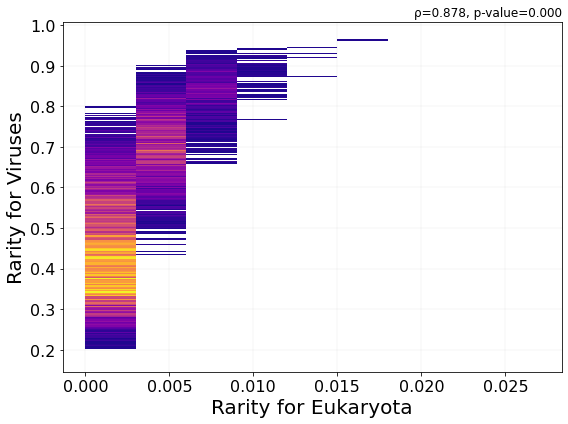

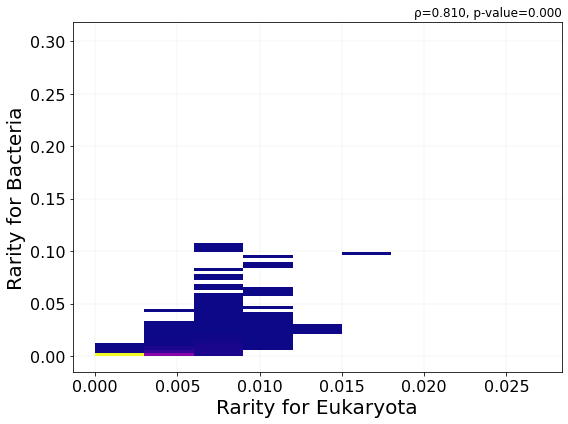

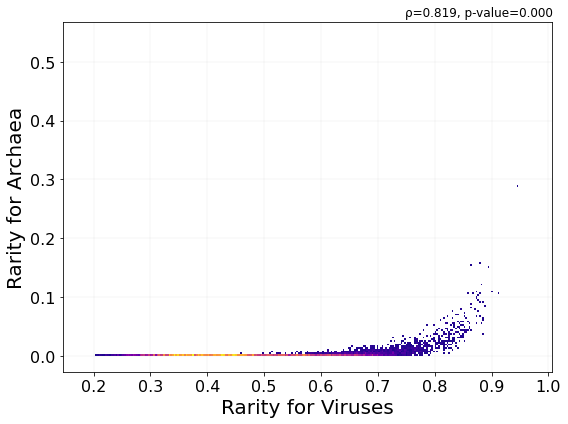

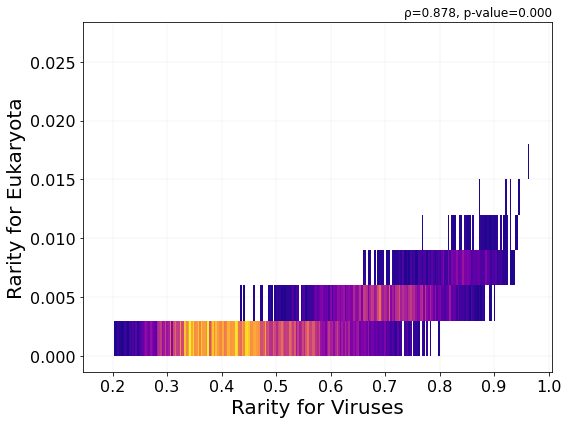

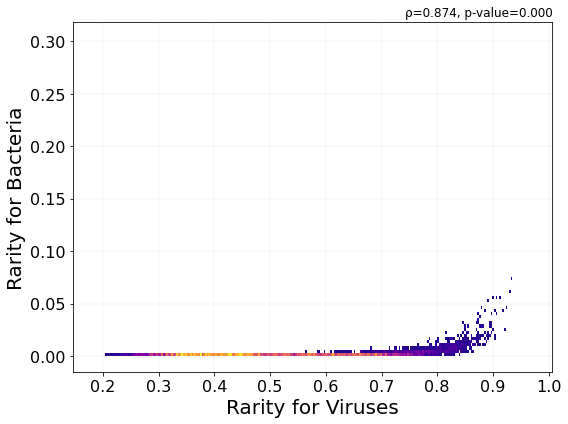

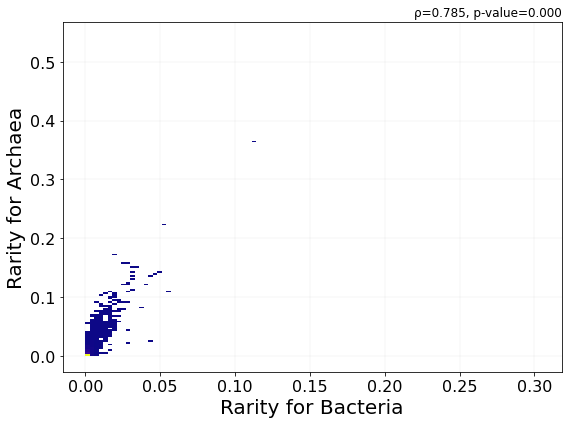

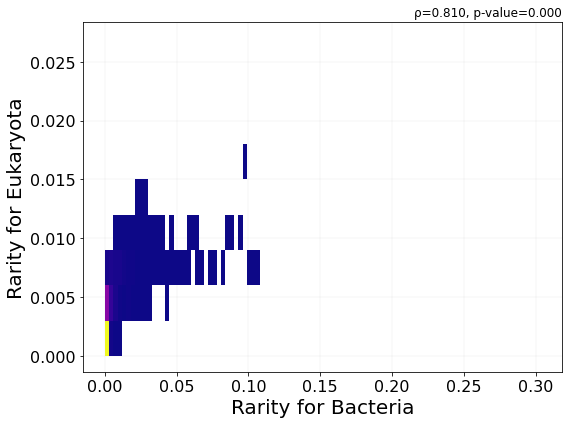

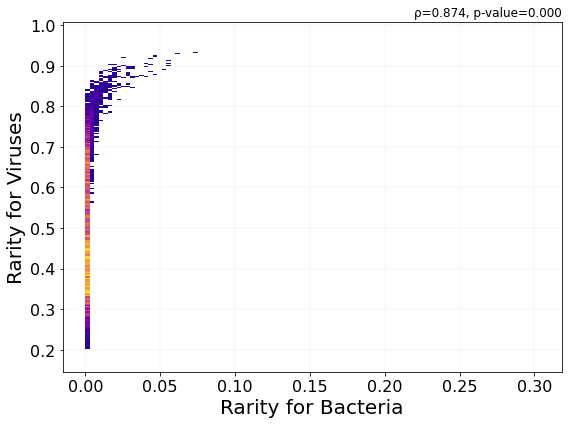


 25%|██▌       | 1/4 [00:04<00:13,  4.44s/it]

Processing Length 4


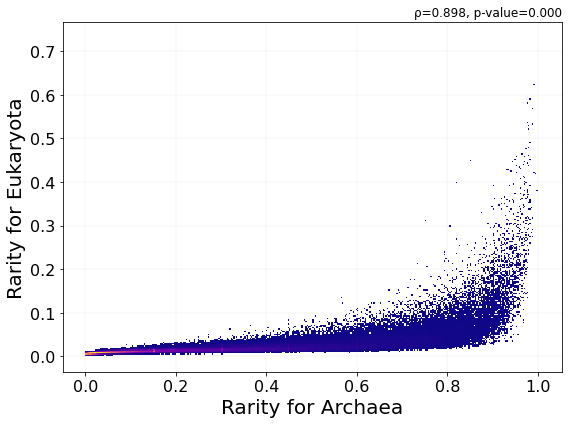

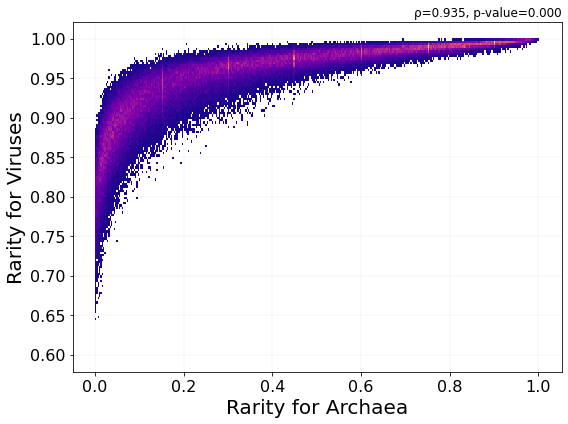

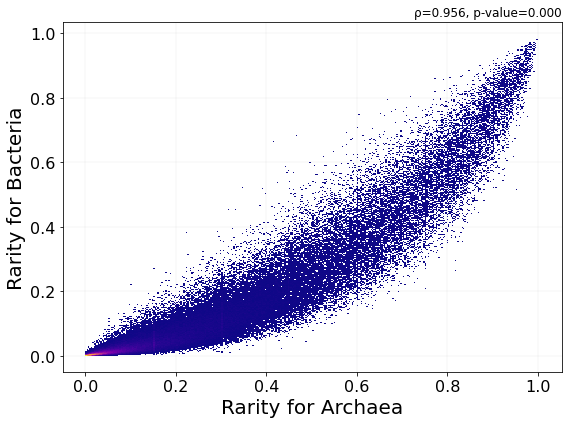

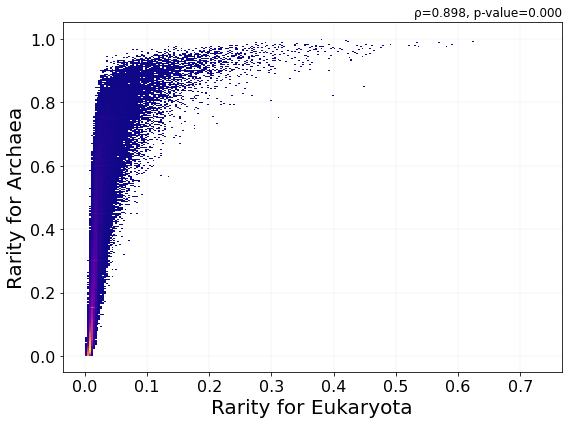

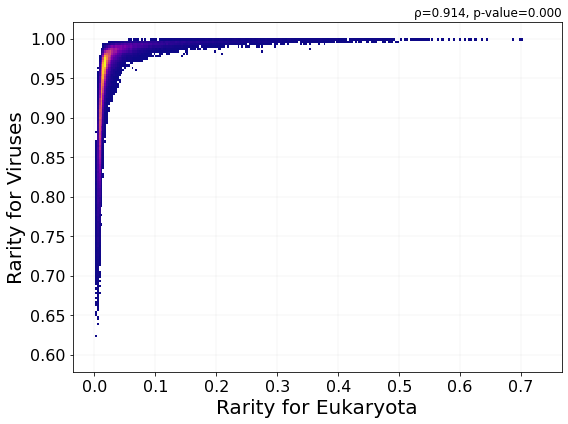

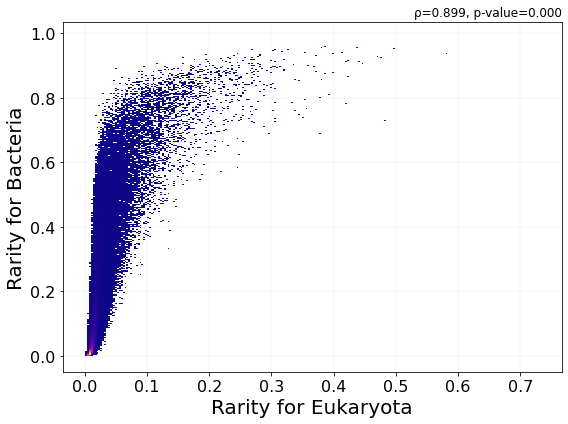

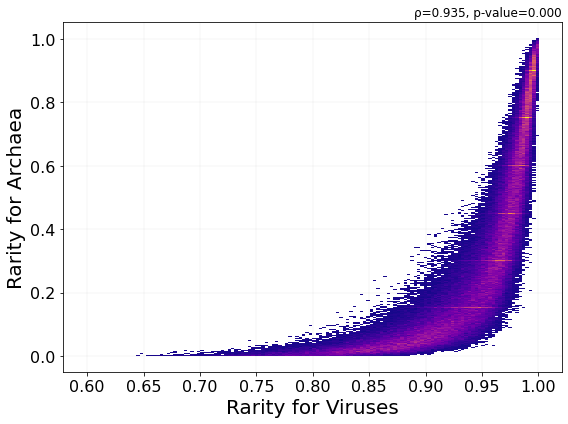

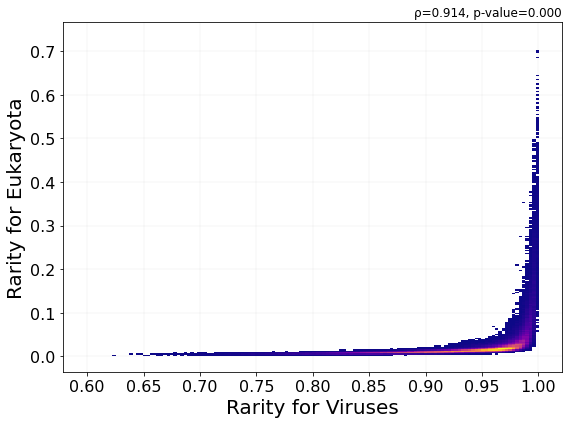

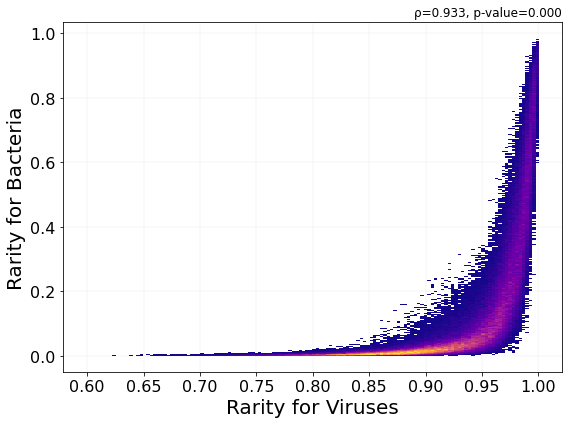

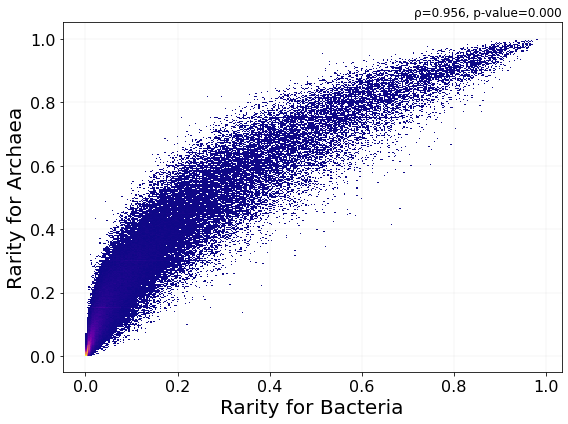

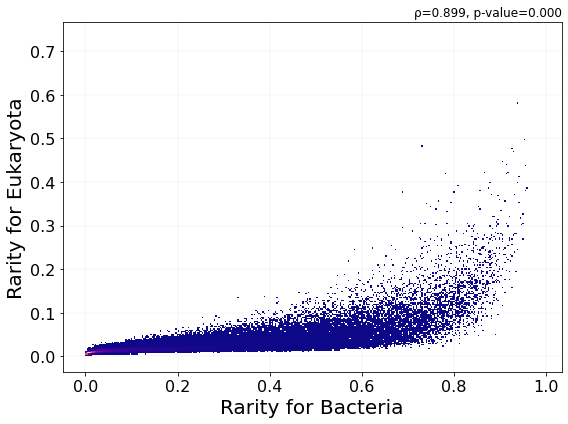

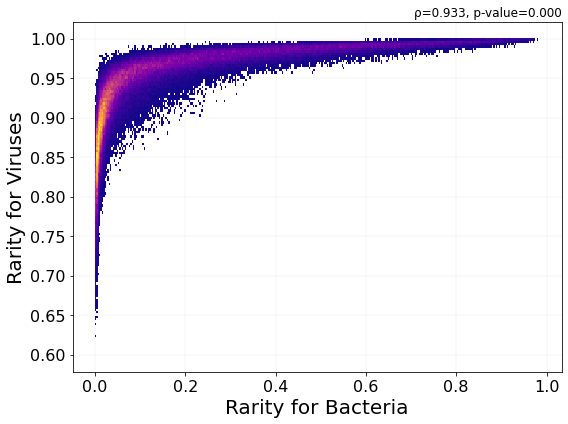


 50%|█████     | 2/4 [00:10<00:11,  5.55s/it]

Processing Length 5


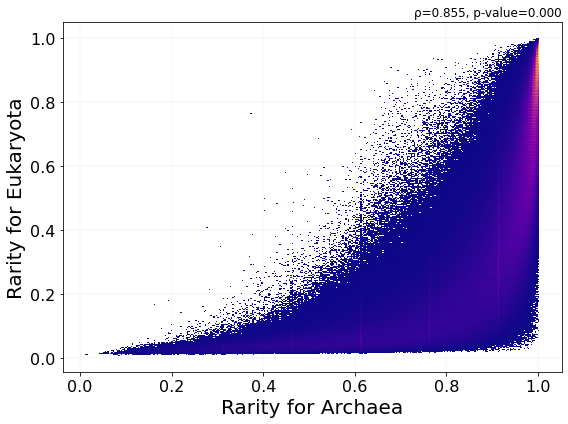

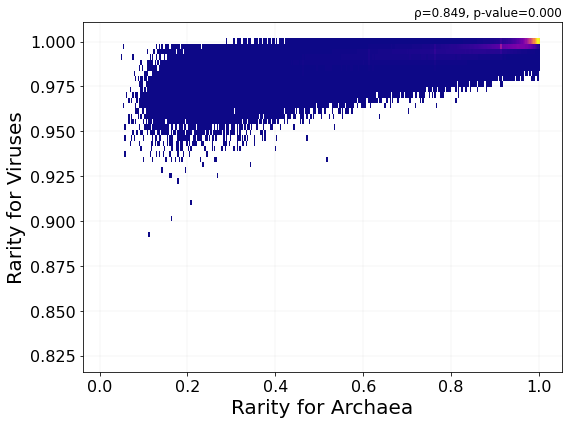

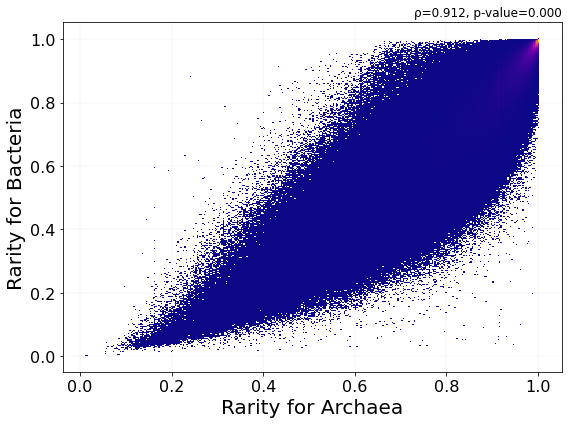

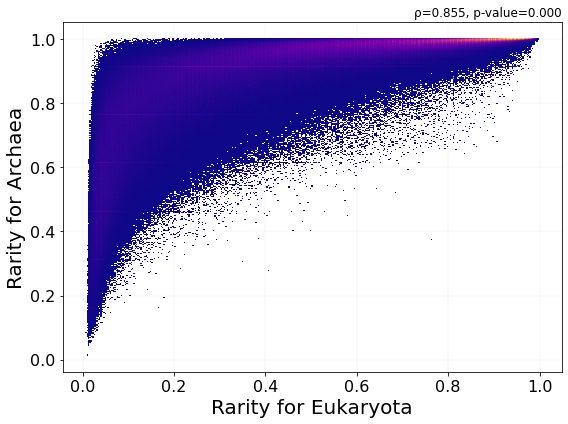

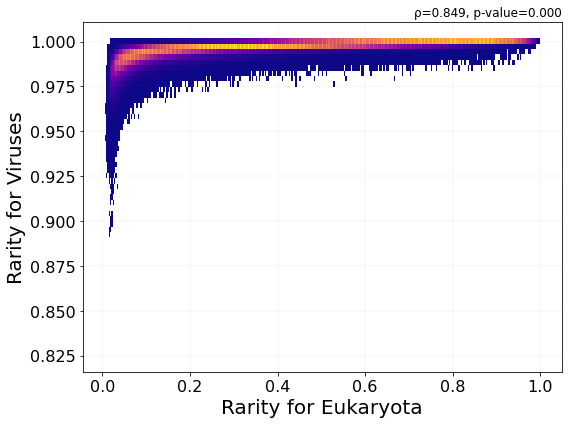

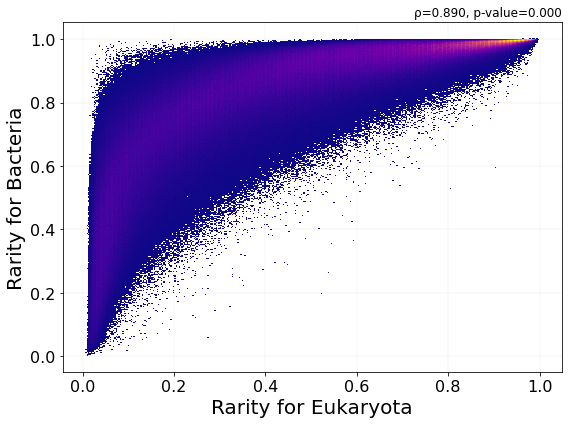

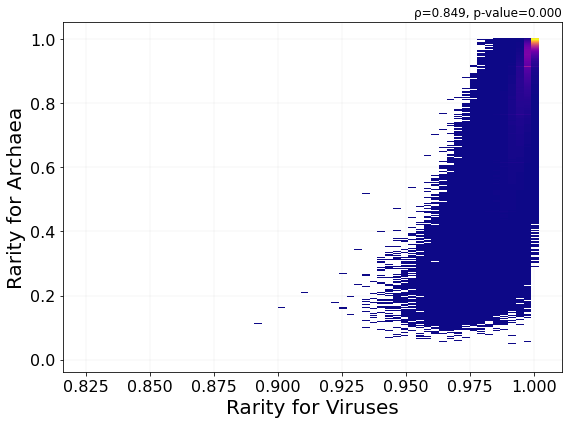

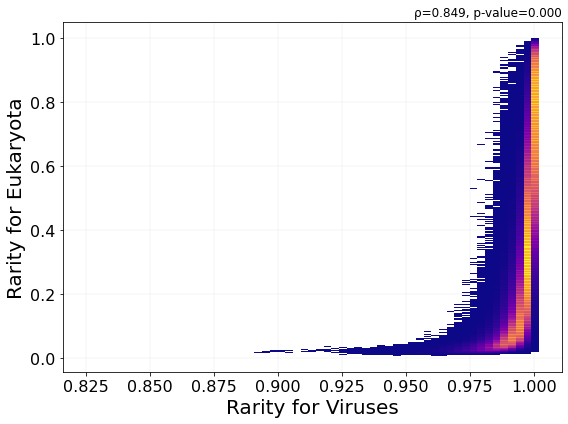

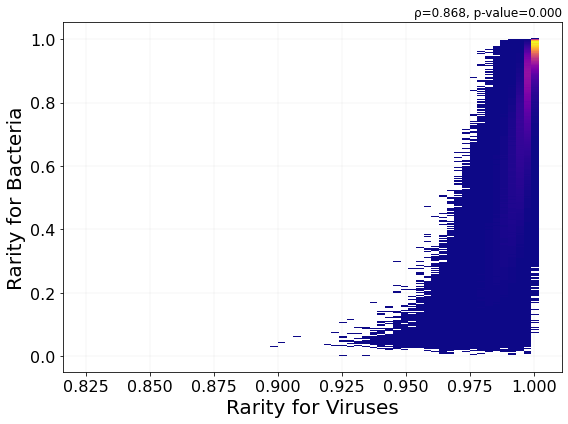

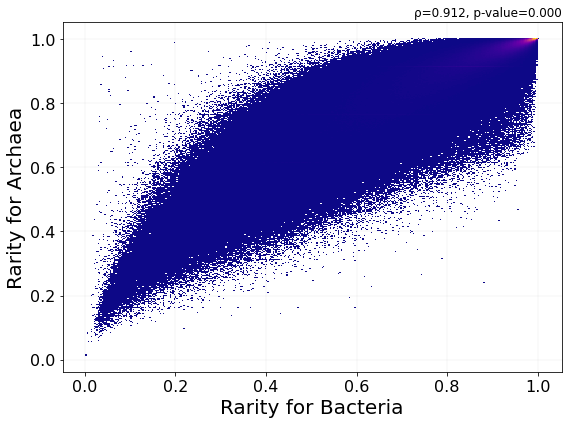

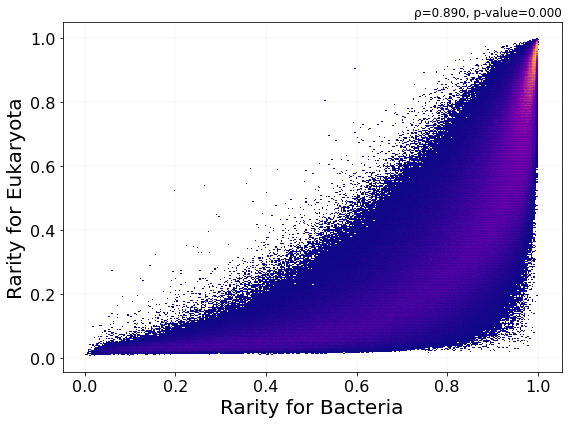

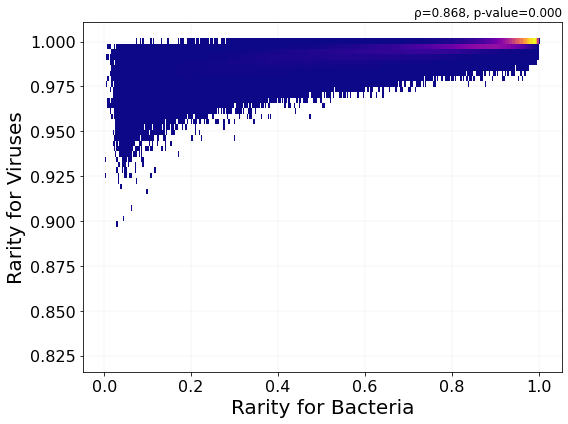


 75%|███████▌  | 3/4 [00:55<00:23, 23.59s/it]

Processing Length 6


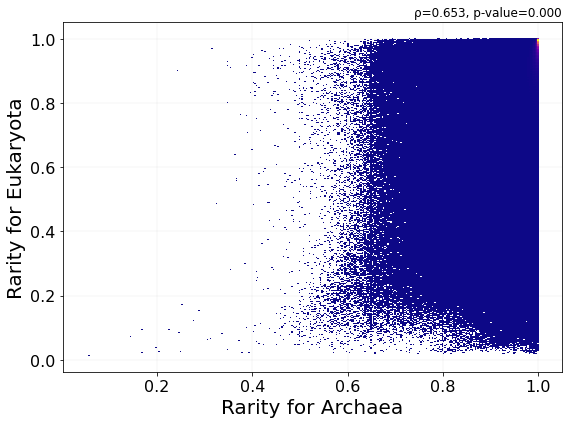

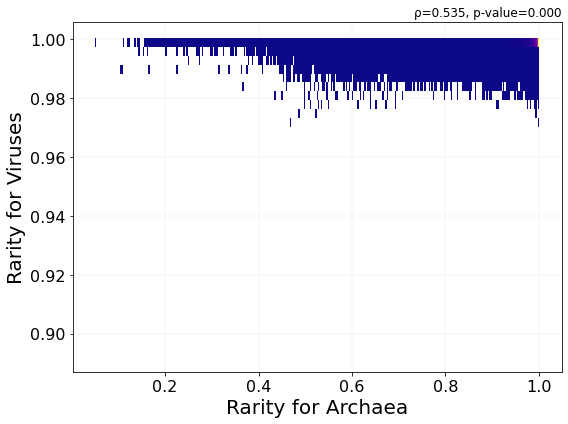

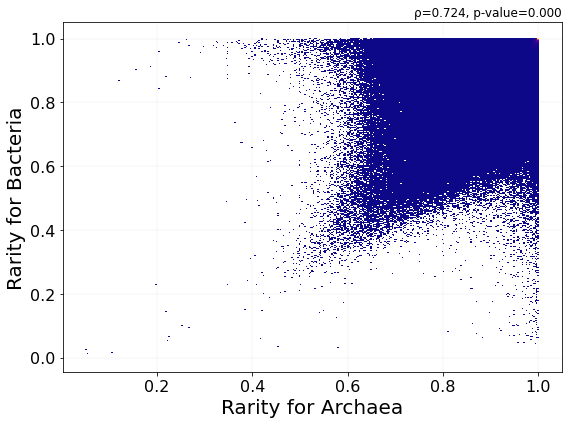

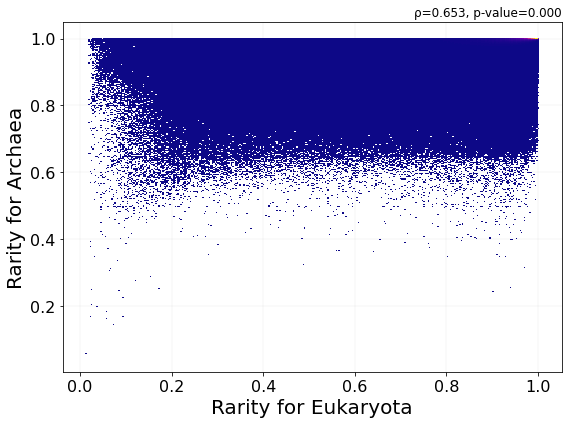

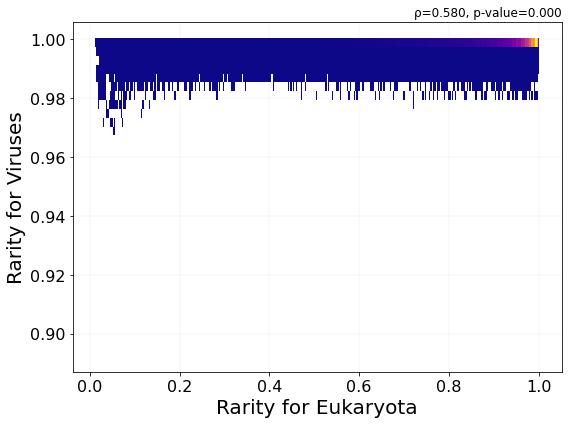

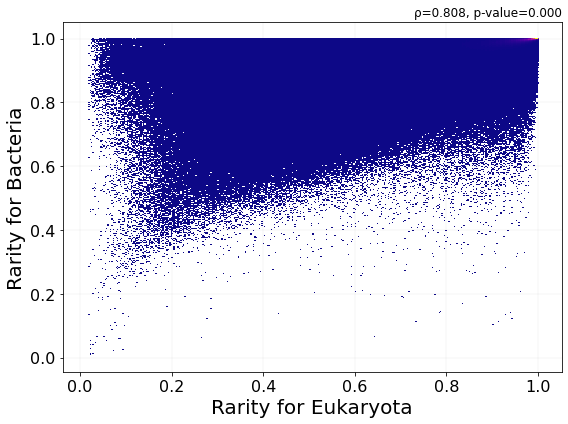

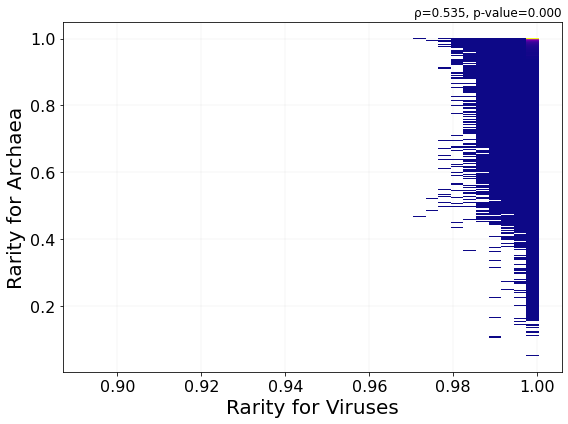

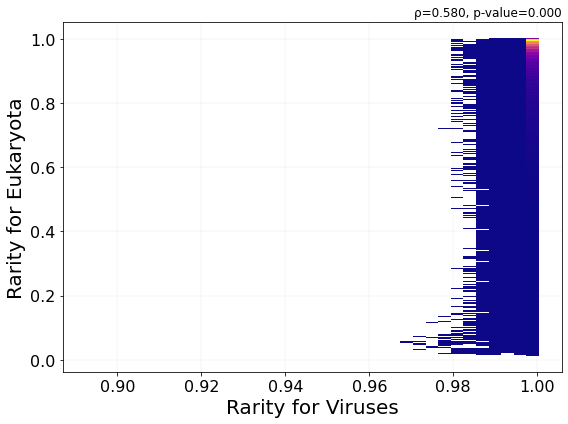

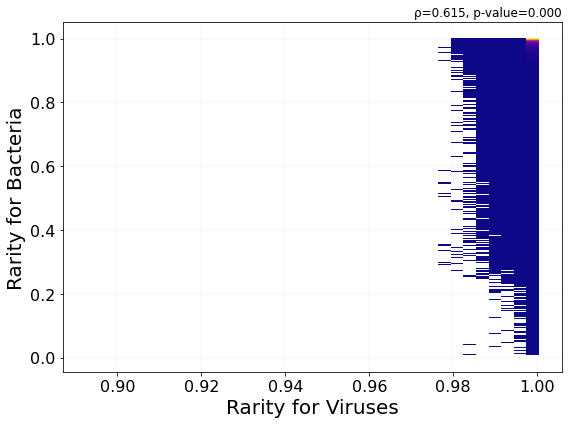

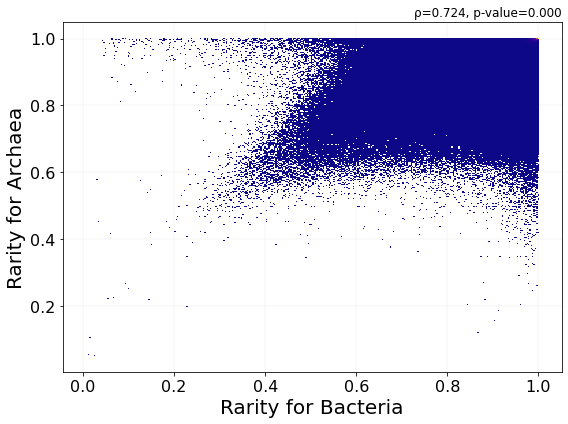

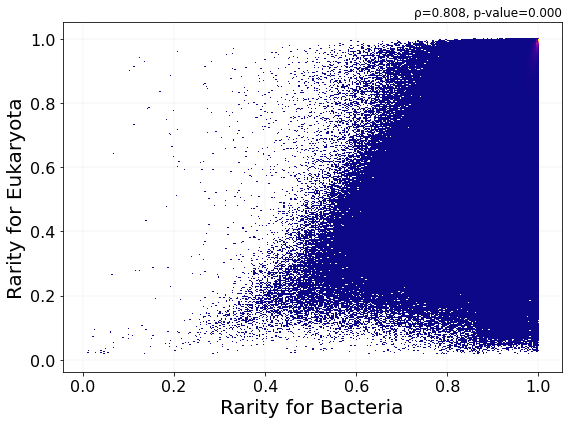

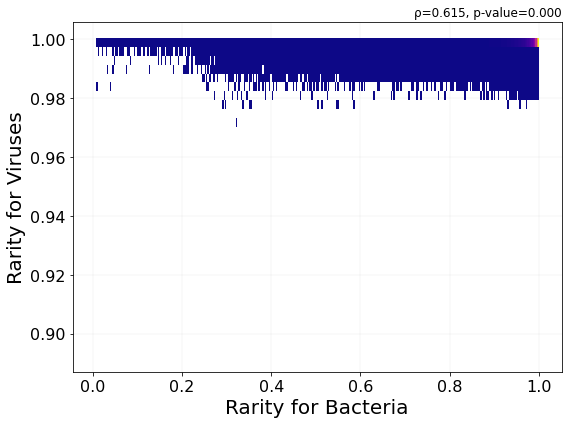


100%|██████████| 4/4 [18:37<00:00, 279.35s/it]


In [102]:
from scipy.stats import spearmanr

for length in tqdm(range(3, 7)):
    print(f"Processing Length {length}")
    kmers_chunk = df_kmers[df_kmers["length"] == length]
    taxonomies = ["Rarity for Archaea",
                  "Rarity for Eukaryota",
                  "Rarity for Viruses",
                  "Rarity for Bacteria"]
    for taxonomy in taxonomies:
        for taxonomy2 in taxonomies:   
            if taxonomy == taxonomy2:
                continue
                  
            chunk = kmers_chunk[[taxonomy, taxonomy2]]
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))            
            spear, pvalue = spearmanr(chunk[taxonomy], chunk[taxonomy2])
            sns.histplot(data=chunk, 
                        x=taxonomy,
                        y=taxonomy2, 
                         ax=ax,
                         binwidth=0.003,
                         pthresh=0.0,
                         zorder=3,
                         cmap="plasma",
                        )
            ax.set_title(f"ρ={spear:.3f}, p-value={pvalue:.3f}", loc="right")
            ax.title.set_size(14)
            ax.xaxis.label.set_size(20)
            ax.yaxis.label.set_size(20)
            ax.tick_params(which="major", labelsize=16, axis="both")
            ax.grid(lw=0.4, alpha=0.3, zorder=0)
            plt.tight_layout()
            plt.show()